<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 3: прогнозирование временных рядов</center></h2>

In [1]:
# !pip install -r requirements.txt
!wget https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw3/requirements.txt

--2023-05-13 19:41:03--  https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw3/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]      77  --.-KB/s    in 0s      

2023-05-13 19:41:03 (2.89 MB/s) - ‘requirements.txt’ saved [77/77]



In [2]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.2/273.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 88.4 MB/s eta 0:00:00
     ━━━━━━━━━━

In [3]:
!pip install etna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [63]:
import warnings
import gdown
import os
import zipfile

import matplotlib.pyplot as plt
import pandas as pd
from etna.analysis import (cross_corr_plot, distribution_plot, plot_anomalies,
                           plot_anomalies_interactive, plot_backtest,
                           plot_correlation_matrix, plot_forecast)
from etna.analysis.outliers import get_anomalies_median
from etna.datasets import TSDataset
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
from etna.metrics import MAE, MAPE, MSE, SMAPE
from etna.models import ProphetModel
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines
from etna.transforms import (DateFlagsTransform, FilterFeaturesTransform,
                             HolidayTransform, LagTransform,
                             LinearTrendTransform, LogTransform, MeanTransform,
                             MedianOutliersTransform, SegmentEncoderTransform,
                             TimeSeriesImputerTransform)

warnings.filterwarnings("ignore")

В данной задаче мы будем решать одну из актуальных практических задач, с которыми, в том числе, сталкиваются разработчики ETNA - прогнозирование объема необходимой наличности в банкоматах (на примере одного устройства). Пожалуй, ни для кого не секрет, что отсутствие необходимой суммы в банкомате не делает клиента банка счастливее. В то же время, избыток заправленной в банкомат наличности приводит к упущенной выгоде - ведь, в конечном счете, эти деньги могли быть размещены в качестве краткосрочного депозита на межбанковском рынке. Для кредитной организации с обширной сетью банкоматов даже незначительное улучшение качества предсказания способно внести значительный вклад в прибыльность этой ветки бизнеса. 

Мы будем использовать дневные данные реального банкомата хоть и не с российского рынка, но очень схожего с ним - турецкого. Скачаем и загрузим их:

In [159]:
url = 'https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv'
output = 'atm_daily_cash.csv'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

df = pd.read_csv('atm_daily_cash.csv')
df = df[4:] #лучше избавиться от нескольких пропущенных значений в начале сразу,
            #могут доставлять ненужные лишние проблемы

Downloading...
From: https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv
To: /content/atm_daily_cash.csv
26.1kB [00:00, 27.1MB/s]                   


Взглянем на то, что представляют из себя данные:

In [160]:
df.head()

Date   CashIn  CashOut
4  1/5/2016  20840.0  22200.0
5  1/6/2016  28460.0  18810.0
6  1/7/2016  19250.0  23210.0
7  1/8/2016  49770.0   4350.0
8  1/9/2016      NaN      NaN

В нашем распоряжении пополнения и изъятия; нас интересует нетто. Для этого будем учитывать изъятия со знаком минус, а нетто определим как сумму (такое представление пригодится нам в дальнейшем).

In [161]:
df['CashOut'] = -df['CashOut']
df['target'] = df['CashIn'] + df['CashOut']

### Задание 1. EDA (1 балл)

Проведите разведывательный анализ данных - постройте графики, на которых можно судить о наличии тренда, сезонности и прочих зависимостей. Проанализируйте корреляции. Какие выводы вы можете сделать?

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

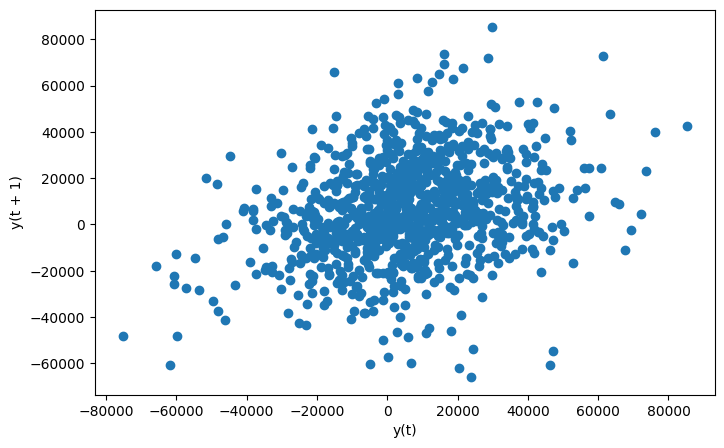

In [162]:
pd.plotting.lag_plot(df["target"], lag=1)

In [163]:
values = pd.DataFrame(df["target"].values)

dataframe = pd.concat([values.shift(7), values.shift(6), values.shift(5),
                       values.shift(4), values.shift(3), values.shift(2),
                       values.shift(1), values], axis=1)

dataframe.columns = ['t', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6', 't+7']
result = dataframe.corr()
print(result)

            t       t+1       t+2       t+3       t+4       t+5       t+6  \
t    1.000000  0.280660  0.129226  0.106371  0.065403  0.076189  0.116217   
t+1  0.280660  1.000000  0.281802  0.128544  0.106943  0.067613  0.075415   
t+2  0.129226  0.281802  1.000000  0.281053  0.129071  0.108839  0.066944   
t+3  0.106371  0.128544  0.281053  1.000000  0.280776  0.128064  0.109028   
t+4  0.065403  0.106943  0.129071  0.280776  1.000000  0.281194  0.127780   
t+5  0.076189  0.067613  0.108839  0.128064  0.281194  1.000000  0.279784   
t+6  0.116217  0.075415  0.066944  0.109028  0.127780  0.279784  1.000000   
t+7  0.131734  0.117715  0.076818  0.066358  0.109562  0.129754  0.278906   

          t+7  
t    0.131734  
t+1  0.117715  
t+2  0.076818  
t+3  0.066358  
t+4  0.109562  
t+5  0.129754  
t+6  0.278906  
t+7  1.000000  


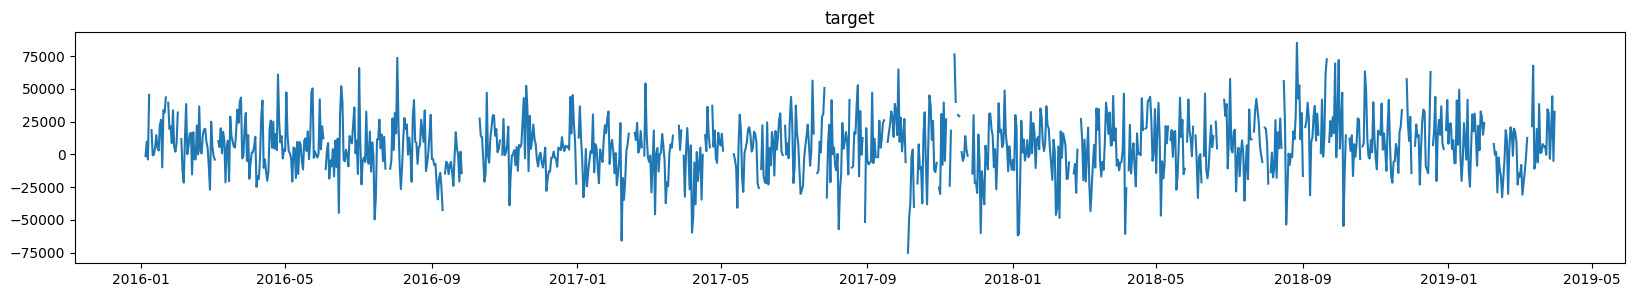

In [164]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(pd.to_datetime(df['Date']), df['target'])
plt.title('target')
plt.show()

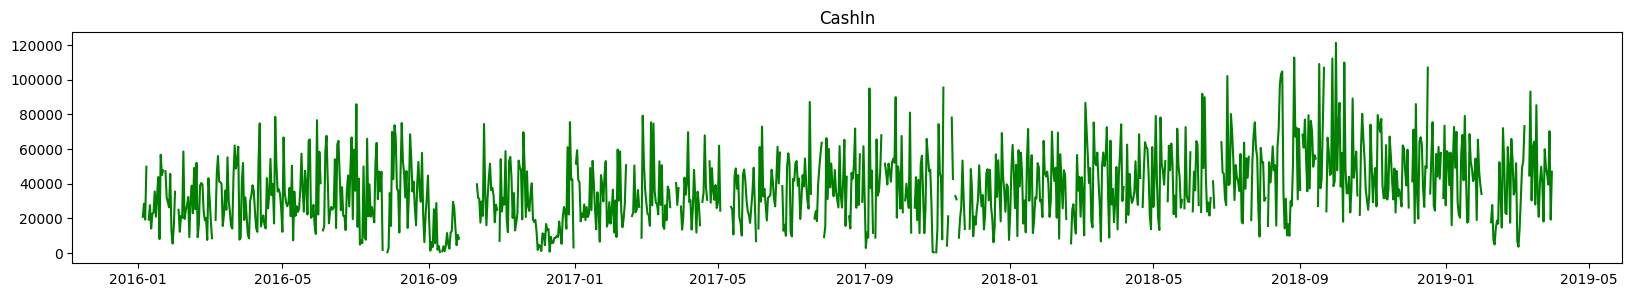

In [165]:
plt.plot(pd.to_datetime(df['Date']), df['CashIn'], c='g')
plt.title('CashIn')
plt.show()

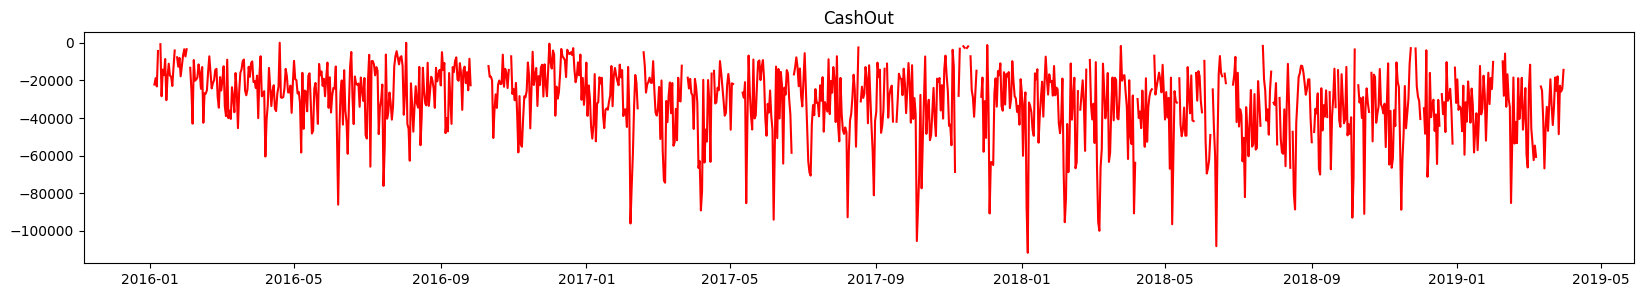

In [166]:
plt.plot(pd.to_datetime(df['Date']), df['CashOut'], c='r')
plt.title('CashOut')
plt.show()

In [167]:
df['dayofweek'] = pd.to_datetime(df['Date']).dt.dayofweek
df['monthofyear'] = pd.to_datetime(df['Date']).dt.month

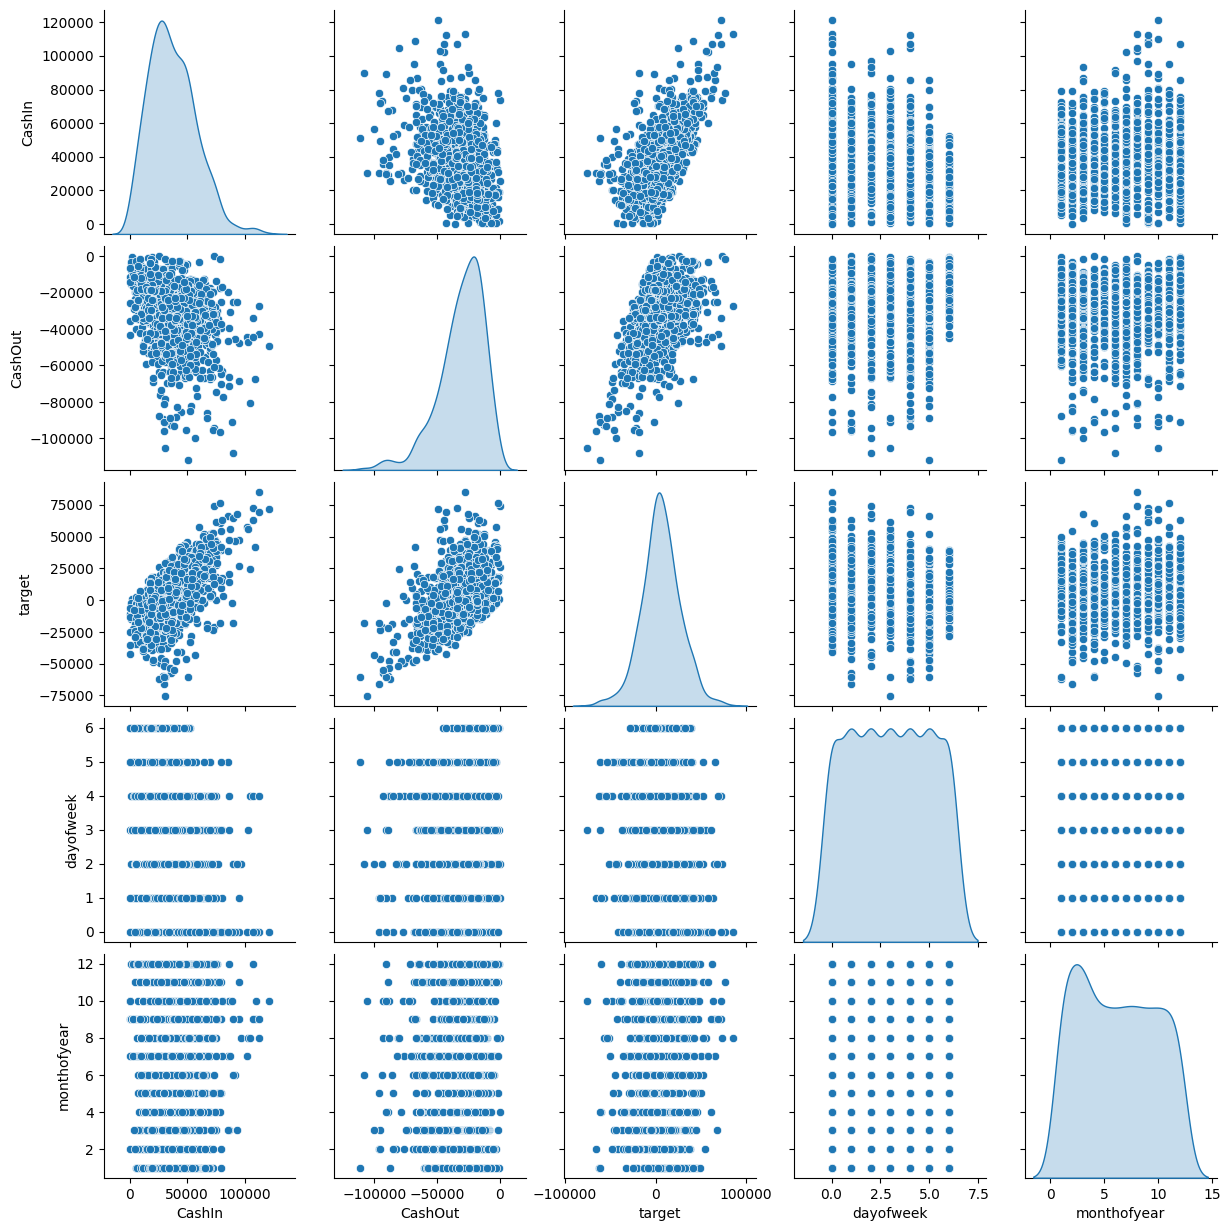

In [168]:
import seaborn as sns
sns.pairplot(df, diag_kind="kde")

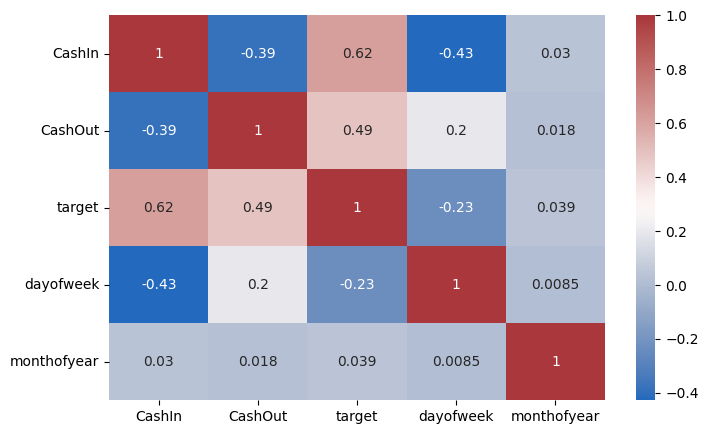

In [169]:
plt.rcParams["figure.figsize"] = (8,5)
cmap = sns.color_palette("vlag", as_cmap=True)
sns.heatmap(df.corr("pearson"), annot=True, cmap=cmap);

In [170]:
df.describe()

CashIn        CashOut        target    dayofweek  monthofyear
count    1081.000000    1094.000000   1072.000000  1182.000000  1182.000000
mean    37261.618871  -30985.648995   5976.651119     3.002538     6.196277
std     20583.186636   18314.048275  21551.659802     1.999787     3.527137
min       100.000000 -111700.000000 -75190.000000     0.000000     1.000000
25%     21690.000000  -40375.000000  -6277.500000     1.000000     3.000000
50%     34980.000000  -27895.000000   5320.000000     3.000000     6.000000
75%     50280.000000  -18010.000000  18515.000000     5.000000     9.000000
max    121300.000000      -0.000000  85160.000000     6.000000    12.000000

Выводы на основе анализа:


*   наблюдается сильная корреляция (0.28) таргета между соседними днями
*   в среднем CashIn увеличивается, а CashOut уменьшается, таргет растет (кстати, у него замечено нормальное распределение)
*   наблюдаются отличительные особенности оборота денег от месяца. Нпример, в месяца 8-10, 12 кладут большие суммы. В 1, 6, 10 большие суммы снимают. Видны смещения таргета в зависимости от дня недели. Например, по воскресеньям разброс меньше, чем в остальные дни. 
*   На тепловой карте корреляций особенно выделены зависимости поступоющих денег от дня недели.


### Задание 2. Приведение в формат multi-segment (0.75 балла)

Теперь нам предстоит (в первый раз) привести данные к формату, в котором с ними будет возможно работать средствами ETNA. Вначале мы будем рассматривать и предсказывать наши данные как мульти-сегментные. Чтобы привести данные в соответствующий формат, вам пригодится функция `pd.melt`. На выходе у нас должен получиться объект `TSDataset`. Поскольку мы будем смотреть на данные не только в этом разрезе, лучше не менять исходный датафрейм и работать с копией.

In [171]:
from etna.datasets import TSDataset

In [172]:
#YOUR CODE HERE#
df1 = pd.melt(df, id_vars=['Date'], value_vars=df.columns[:-2], ignore_index=False)

In [173]:
df1.loc[df1['variable'] == 'target', 'variable'] = '_target_'
df1.sample(5)

Date  variable    value
880   5/30/2018    CashIn  29650.0
1140  2/14/2019    CashIn  16900.0
1155   3/1/2019   CashOut -66320.0
240   8/28/2016    CashIn   6190.0
141   5/21/2016  _target_  -3700.0

In [174]:
df1["timestamp"] = pd.to_datetime(df1["Date"])
df1["target"] = df1["value"]
df1["segment"] = df1["variable"]
df1.drop(columns=["Date", "variable", "value"], inplace=True)
df1.head()

timestamp   target segment
4 2016-01-05  20840.0  CashIn
5 2016-01-06  28460.0  CashIn
6 2016-01-07  19250.0  CashIn
7 2016-01-08  49770.0  CashIn
8 2016-01-09      NaN  CashIn

In [175]:
df2 = df1.copy(deep=True)

In [176]:
df1 = TSDataset.to_dataset(df1)
df1.head()

segment      CashIn  CashOut _target_
feature      target   target   target
timestamp                            
2016-01-05  20840.0 -22200.0  -1360.0
2016-01-06  28460.0 -18810.0   9650.0
2016-01-07  19250.0 -23210.0  -3960.0
2016-01-08  49770.0  -4350.0  45420.0
2016-01-09      NaN      NaN      NaN

### Задание 3. Работа с пропущенными значениями и аутлаерами (1 балл)

Проанализируйте, есть ли в данных пропущенные значения, и подберите оптимальный метод их заполнения средствами ETNA. Какие методы вы выберете и почему? Совет: возможно, лучше сохранить заполненные данные в отдельный объект, поскольку некоторые модели заполняют пропуски встроенными методами, и подача на вход "сырых" данных (на языке временных рядов это данные с нерегулярными интервалами) может принести лучший результат.

Импорты всех необходимых компонент произведите самостоятельно.

In [177]:
ts = TSDataset(df1, freq="D")
ts.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
CashIn        2016-01-05    2019-03-31    1182          101             3   
CashOut       2016-01-05    2019-03-31    1182           88             3   
_target_      2016-01-05    2019-03-31    1182          110             3   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
CashIn            0               0                 0    D  
CashOut           0               0                 0    D  
_target_          0               0                 0    D

Есть пропуски. Заполним их вместе с очисткой аутлаеров. Знаю только метод TimeSeriesImputerTransform. Он дает возможность выбрать стратегию заполнения пропусков. Разумно заполнять пропуски средним значением по месяцу, так как пропущенных данных в 10 раз меньше исходных.

Проверьте ряды на наличие аутлаеров, и очистите их соответствующим образом. Обоснуйте выбор.

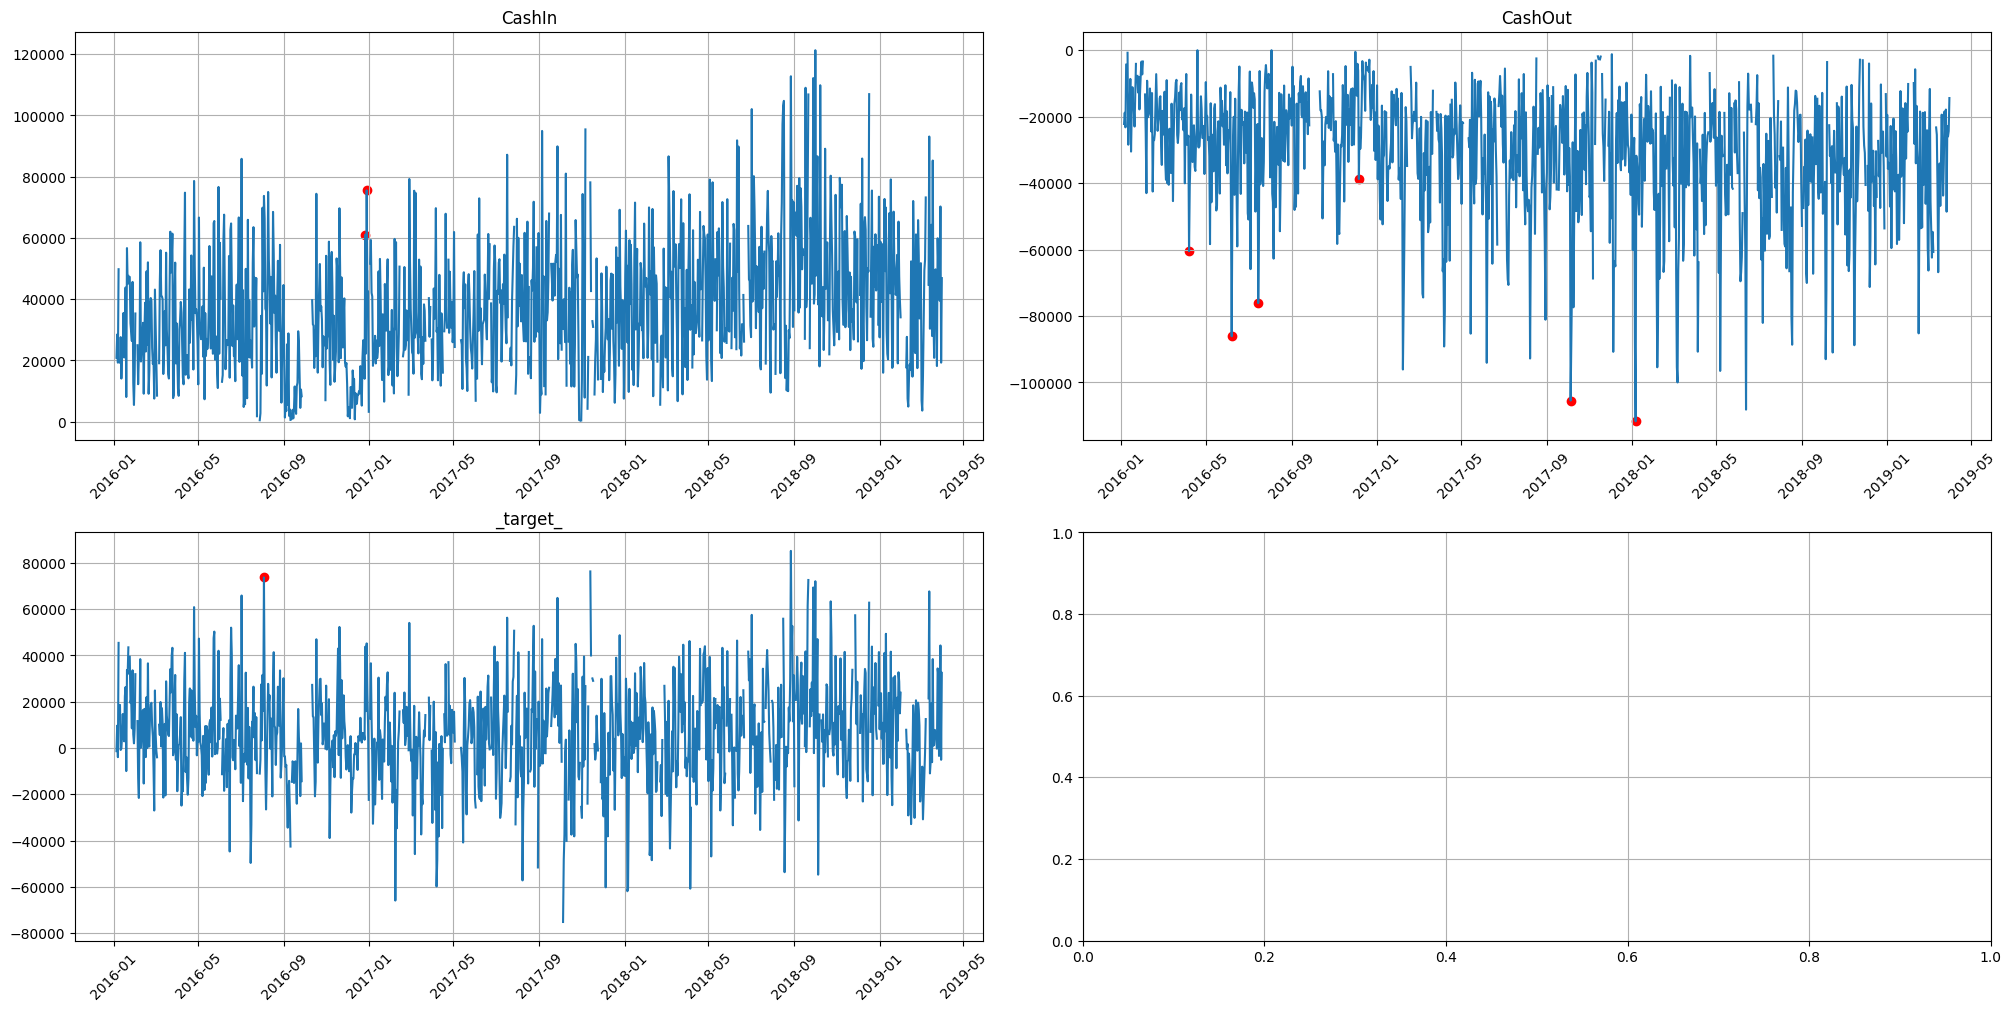

In [178]:
from etna.analysis.outliers import get_anomalies_median, get_anomalies_density
from etna.analysis import plot_anomalies
anomaly_dict = get_anomalies_median(ts, window_size=30)
plot_anomalies(ts, anomaly_dict)

Выделила выбросы по месяцам медианным методом, потому что он позволяет найти аутлаеры по заданному окну. Это самый простой метод, позволяющим самостоятельно выбрать область определения аномалий. Для избавления от них воспользуюсь также заполнением медианными значениями в рамках месяца.

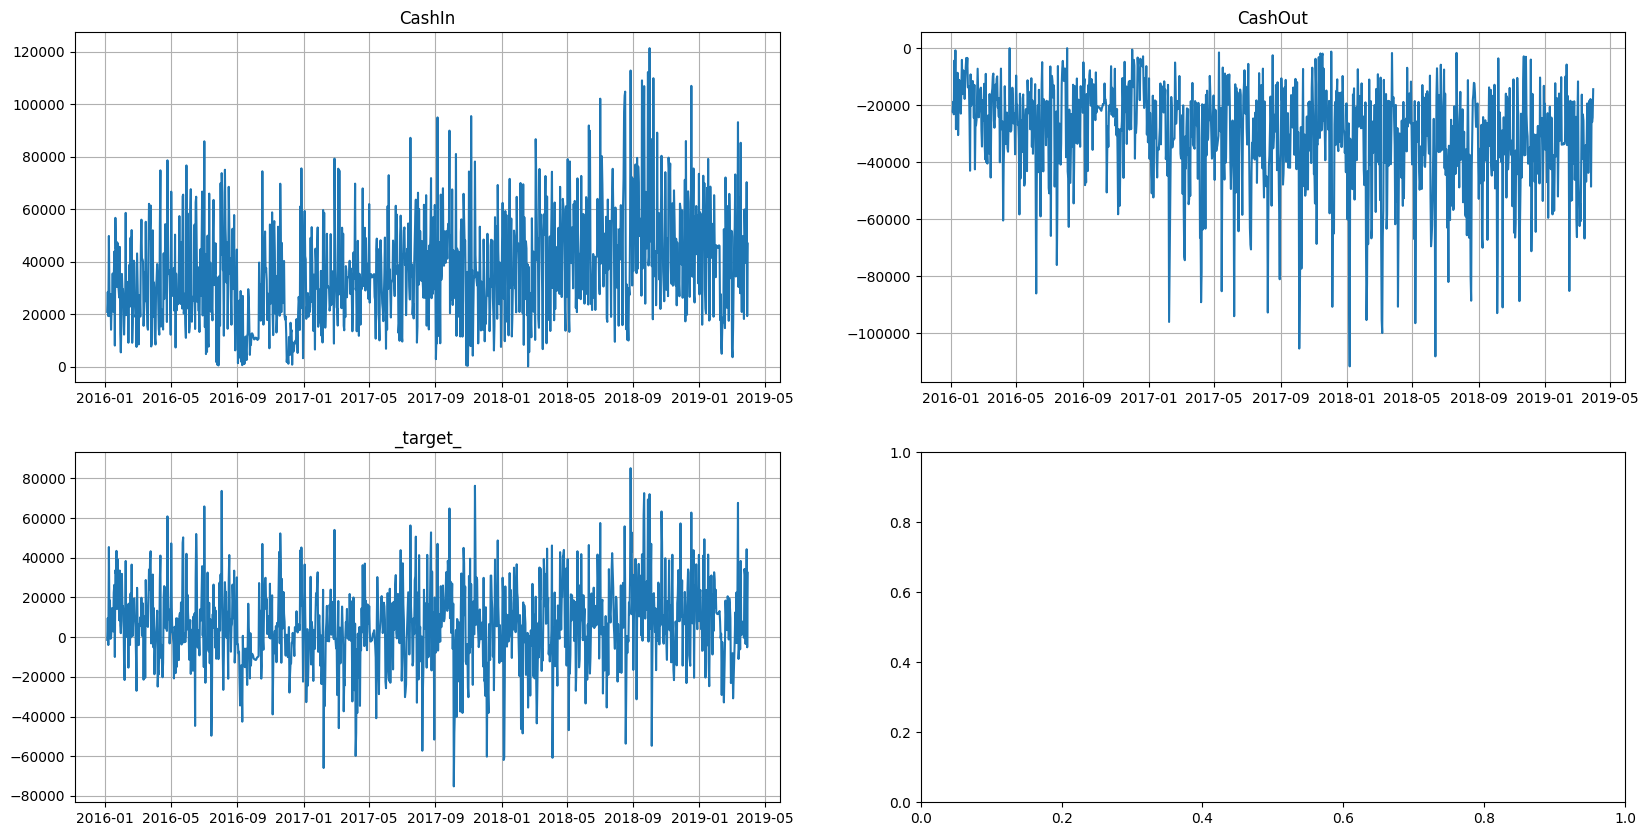

In [179]:
outliers_remover = MedianOutliersTransform(in_column="target")
outliers_imputer = TimeSeriesImputerTransform(
    in_column="target", strategy="running_mean", window=30
)
ts.fit_transform([outliers_remover, outliers_imputer])
ts.plot()

In [180]:
ts.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
CashIn        2016-01-05    2019-03-31    1182            0             3   
CashOut       2016-01-05    2019-03-31    1182            0             3   
_target_      2016-01-05    2019-03-31    1182            0             3   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
CashIn            0               0                 0    D  
CashOut           0               0                 0    D  
_target_          0               0                 0    D

### Задание 4. Построение мультисегментной модели (1.25 балла)

Постройте мульти-сегментную модель на основе Prophet, и оцените качество по SMAPE на кросс-валидации. В качестве горизонта предсказания возьмите 5 дней - этого же горизонта будем придерживаться и в дальнейшем.

Отрисуйте получившийся прогноз.

In [181]:
train_ts, test_ts = ts.train_test_split(
    train_start="2016-01-05",
    train_end="2019-03-26",
    test_start="2019-03-27",
    test_end="2019-03-31",
)

In [182]:
from etna.pipeline import Pipeline
from etna.models import ProphetModel
from etna.metrics import SMAPE
from etna.analysis import plot_backtest

In [183]:
HORIZON = 5

In [184]:
model = ProphetModel() 
transforms = []
pipeline_prophet = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

In [185]:
metrics_df, forecast_df, fold_info_df = pipeline_prophet.backtest(
    ts=ts, metrics=[SMAPE()], aggregate_metrics=True
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2f4anepr/b8uillq8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2f4anepr/u9cs1ghr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52971', 'data', 'file=/tmp/tmp2f4anepr/b8uillq8.json', 'init=/tmp/tmp2f4anepr/u9cs1ghr.json', 'output', 'file=/tmp/tmpvtwxm0ic/prophet_model-20230513221158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:11:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:11:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True t

In [100]:
metrics_df

segment       SMAPE
0    CashIn   32.751691
1   CashOut   35.907964
2  _target_  133.953845

In [101]:
forecast_df.head()

segment         CashIn                   CashOut                  _target_  \
feature    fold_number        target fold_number        target fold_number   
timestamp                                                                    
2019-03-07           0  52363.490692           0 -42576.721505           0   
2019-03-08           0  51282.750421           0 -46627.630374           0   
2019-03-09           0  45313.760246           0 -46043.032321           0   
2019-03-10           0  35788.073667           0 -29084.666231           0   
2019-03-11           0  66170.722137           0 -46571.962417           0   

segment                   
feature           target  
timestamp                 
2019-03-07  10208.747222  
2019-03-08   5354.188223  
2019-03-09     96.383455  
2019-03-10   7300.582372  
2019-03-11  19276.997244

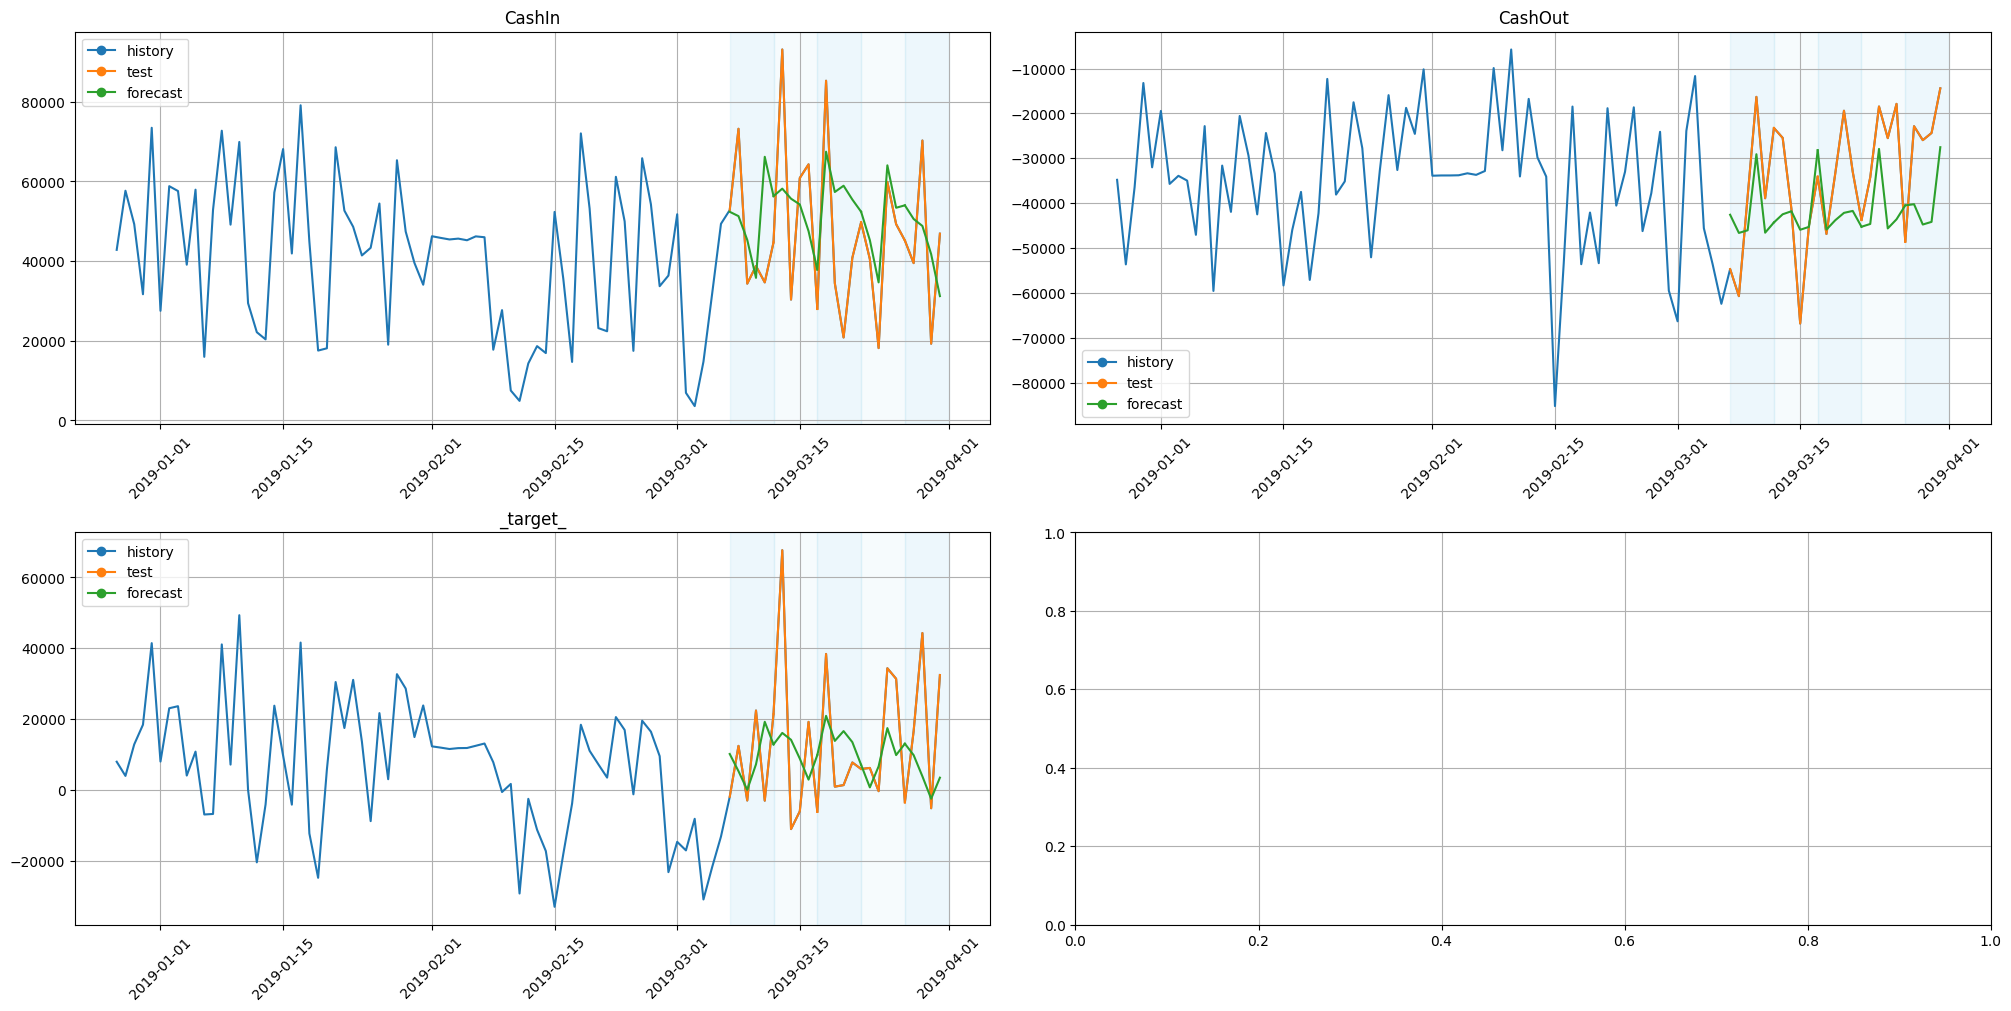

In [102]:
plot_backtest(forecast_df, ts, history_len=70)

Исходя из статистики по каждому ряду, какой можно сделать вывод о том, как лучше предсказывать итоговое значение? Посчитайте то же самое исходя из MAE.

Полагаю, что среднее значение примерно попало, но предсказания совесм не сходятся. 

In [186]:
metrics_df, forecast_df, fold_info_df = pipeline_prophet.backtest(
    ts=ts, metrics=[MAE()], aggregate_metrics=True
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2f4anepr/zo4ccz_k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2f4anepr/twn3nxjy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70131', 'data', 'file=/tmp/tmp2f4anepr/zo4ccz_k.json', 'init=/tmp/tmp2f4anepr/twn3nxjy.json', 'output', 'file=/tmp/tmpz_8hag1f/prophet_model-20230513221858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:18:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:18:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True t

In [104]:
metrics_df

segment           MAE
0    CashIn  15124.528212
1   CashOut  12284.460984
2  _target_  15631.580661

In [105]:
forecast_df.head()

segment         CashIn                   CashOut                  _target_  \
feature    fold_number        target fold_number        target fold_number   
timestamp                                                                    
2019-03-07           0  52363.490692           0 -42576.721505           0   
2019-03-08           0  51282.750421           0 -46627.630374           0   
2019-03-09           0  45313.760246           0 -46043.032321           0   
2019-03-10           0  35788.073667           0 -29084.666231           0   
2019-03-11           0  66170.722137           0 -46571.962417           0   

segment                   
feature           target  
timestamp                 
2019-03-07  10208.747222  
2019-03-08   5354.188223  
2019-03-09     96.383455  
2019-03-10   7300.582372  
2019-03-11  19276.997244

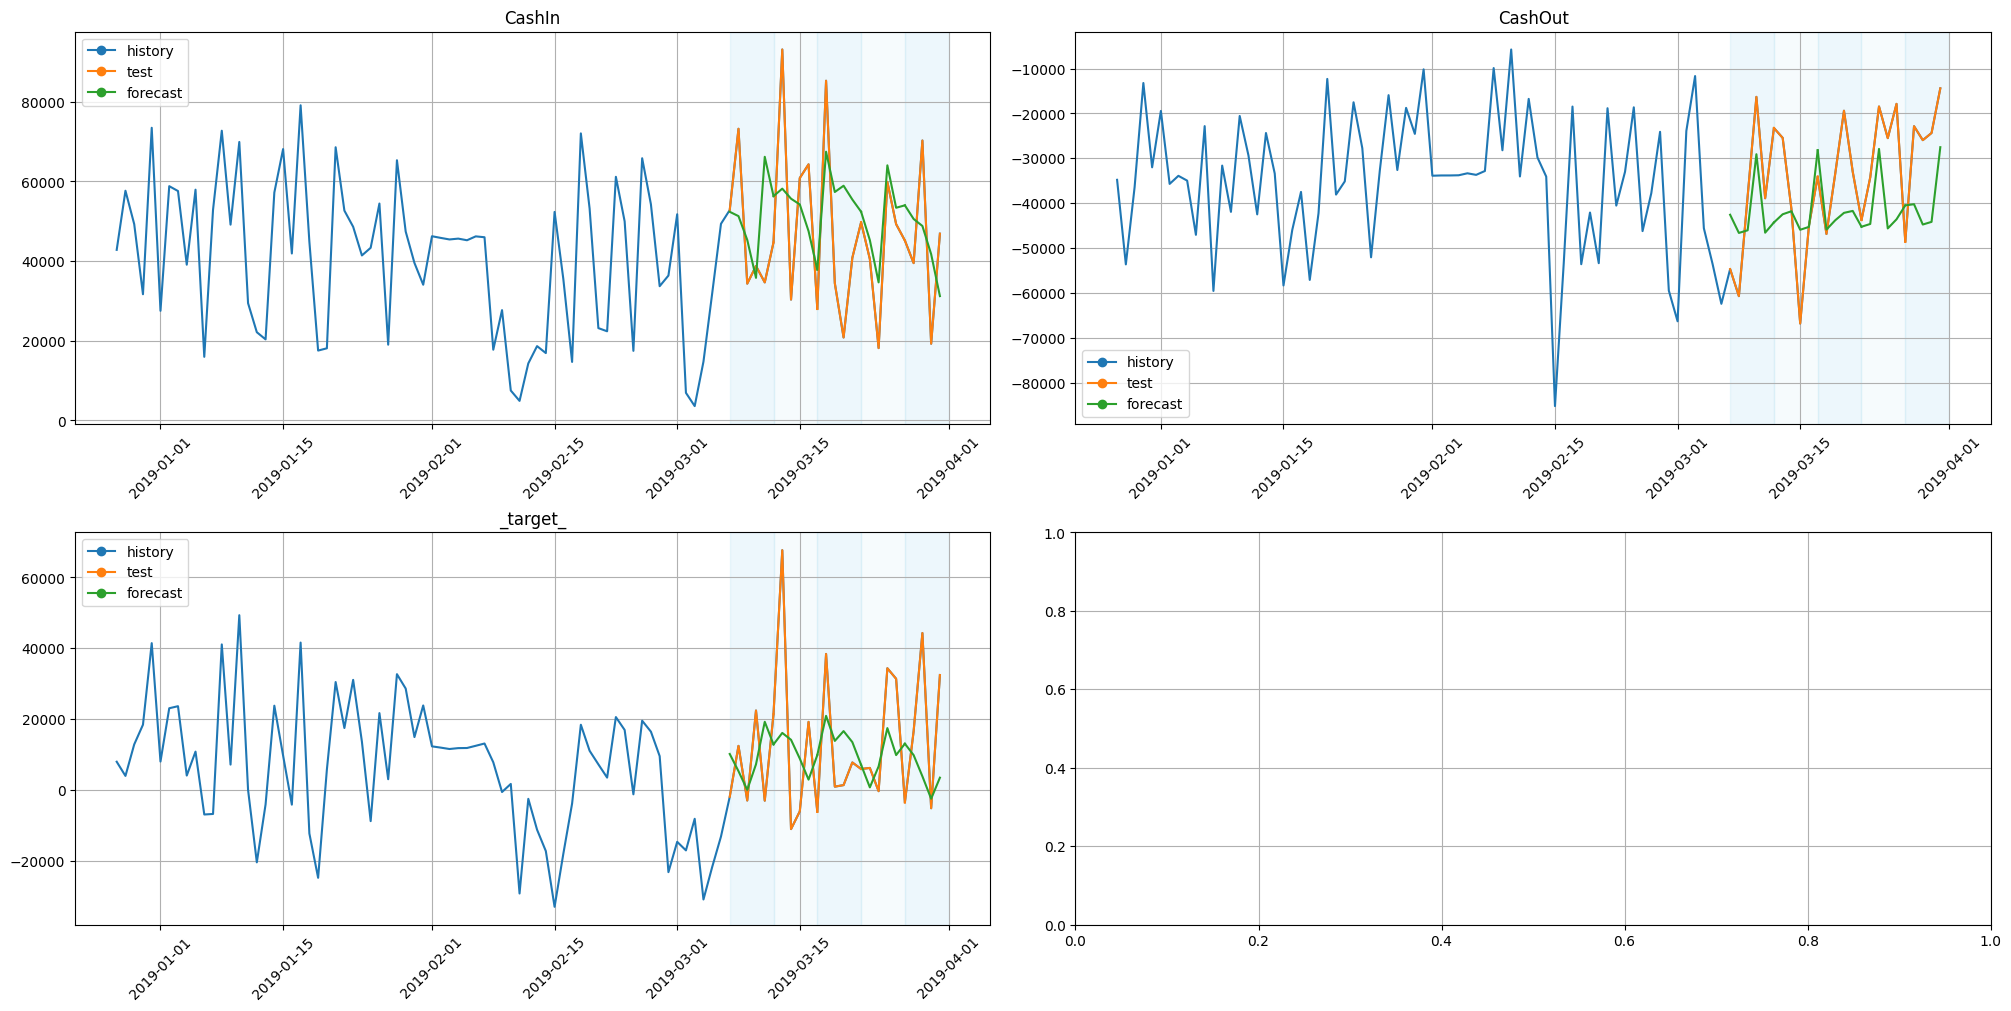

In [106]:
plot_backtest(forecast_df, ts, history_len=70)

Странные предсказания. Наблюдается четкая переодичность в них.

### Задание 5. Иерархический временной ряд (2 балла)

Вопрос, поставленный в прошлом задании, тем не менее, естественным образом подводит нас к концепции **иерархического временного ряда** (когда один ряд состоит из других в качестве компонент). Это полезная концепция, которая может встретиться во многих задачах. В этом задании вам предстоит самостоятельно разобраться в деталях ее реализации в ETNA с использованием справочных материалов, предоставляемых библиотекой (как это часто бывает на практике). Они содержатся по следующей ссылке:

https://github.com/tinkoff-ai/etna/blob/master/examples/hierarchical_pipeline.ipynb

На выходе из первой части задания необходимо получить `TSDataset` с иерархической структурой, а также соответствующий реконсилятор, который позволит собирать искомый ряд из составных компонент. Классы, которые вам понадобятся, импортированы ниже.

In [187]:
from etna.datasets import HierarchicalStructure
from etna.pipeline import HierarchicalPipeline
from etna.reconciliation import BottomUpReconciliator

In [188]:
df2 = pd.melt(df[df.columns[:-2]], id_vars=['Date'], value_vars=df.columns[:-2], ignore_index=False)
df2.loc[df2['variable'] == 'target', 'variable'] = '_target_'
df2["timestamp"] = pd.to_datetime(df2["Date"])
df2["cash_level"] = df2["variable"]
df2["target"] = df2["value"]
df2.drop(columns=["Date", "variable", "value"], inplace=True)
df2.sample(5)

timestamp cash_level   target
968 2018-08-26     CashIn  51130.0
911 2018-06-30     CashIn  31390.0
7   2016-01-08    CashOut  -4350.0
893 2018-06-12    CashOut -60170.0
279 2016-10-06   _target_      NaN

In [189]:
hierarchical_df, hierarchical_structure = TSDataset.to_hierarchical_dataset(
    df=df2[df2['cash_level'] != '_target_'], level_columns=["cash_level"]
)

hierarchical_df.head()

segment      CashIn  CashOut
feature      target   target
timestamp                   
2016-01-05  20840.0 -22200.0
2016-01-06  28460.0 -18810.0
2016-01-07  19250.0 -23210.0
2016-01-08  49770.0  -4350.0
2016-01-09      NaN      NaN

In [190]:
hierarchical_structure

HierarchicalStructure(level_structure = {'total': ['CashIn', 'CashOut']}, level_names = ['total', 'cash_level'], )

In [191]:
hierarchical_ts = TSDataset(df=hierarchical_df, 
                            freq="D", hierarchical_structure=hierarchical_structure)

hierarchical_ts.head()

segment      CashIn  CashOut
feature      target   target
timestamp                   
2016-01-05  20840.0 -22200.0
2016-01-06  28460.0 -18810.0
2016-01-07  19250.0 -23210.0
2016-01-08  49770.0  -4350.0
2016-01-09      NaN      NaN

In [192]:
reconciliator = BottomUpReconciliator(target_level="total", source_level="cash_level")

In [193]:
reconciliator.fit(ts=hierarchical_ts)
reconciliator.mapping_matrix.toarray()
reconciliator.aggregate(ts=hierarchical_ts).head(5)

segment      CashIn  CashOut
feature      target   target
timestamp                   
2016-01-05  20840.0 -22200.0
2016-01-06  28460.0 -18810.0
2016-01-07  19250.0 -23210.0
2016-01-08  49770.0  -4350.0
2016-01-09      NaN      NaN

Во второй части задания примените найденные на предыдущих этапах преобразования очистку от аутлаеров уже к иерархическому датасету, и запустите на нем Prophet с MAE на кросс-валидации.

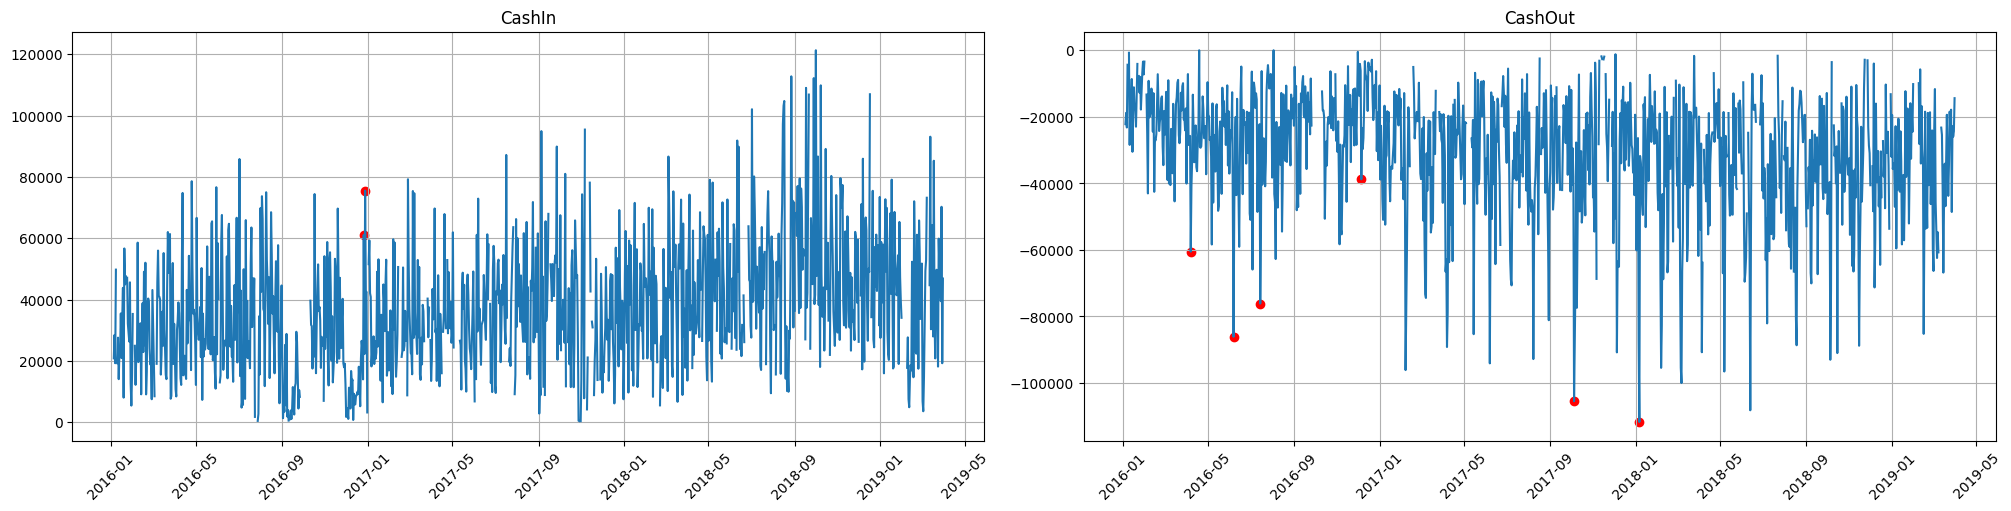

In [194]:
anomaly_dict = get_anomalies_median(hierarchical_ts, window_size=30)
plot_anomalies(hierarchical_ts, anomaly_dict)

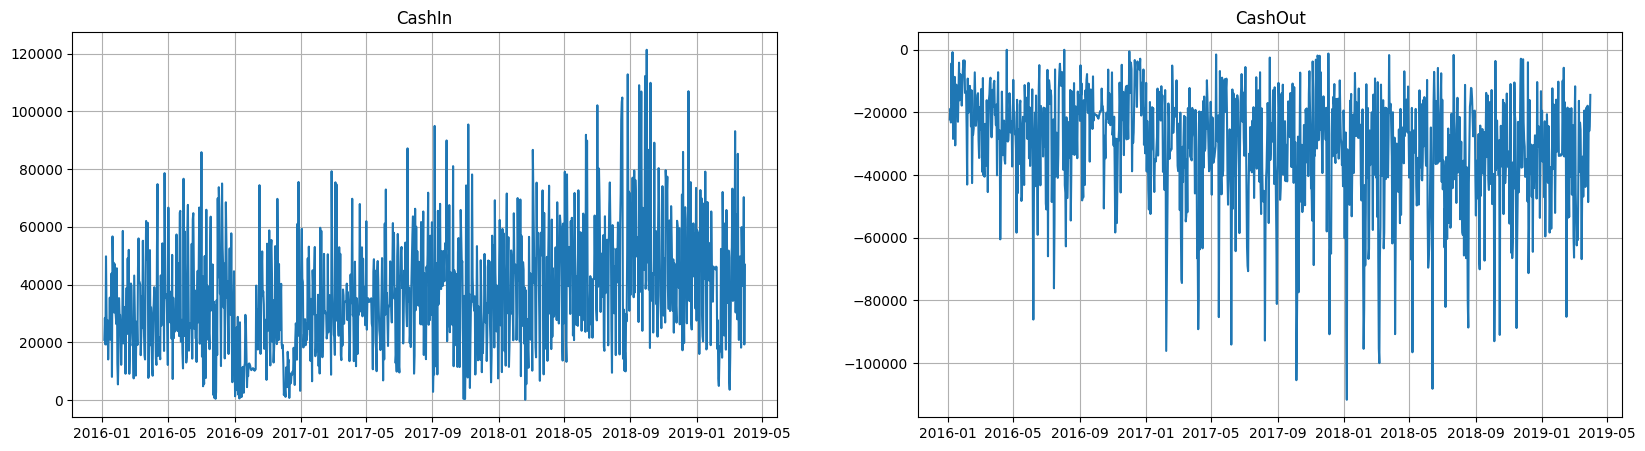

In [195]:
outliers_remover = MedianOutliersTransform(in_column="target")
outliers_imputer = TimeSeriesImputerTransform(
    in_column="target", strategy="running_mean", window=30
)
hierarchical_ts.fit_transform([outliers_remover, outliers_imputer])
hierarchical_ts.plot()

In [196]:
hierarchical_ts.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
CashIn        2016-01-05    2019-03-31    1182            0             2   
CashOut       2016-01-05    2019-03-31    1182            0             2   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
CashIn            0               0                 0    D  
CashOut           0               0                 0    D

In [197]:
#YOUR CODE HERE#
pipeline = HierarchicalPipeline(
    transforms=transforms,
    model=ProphetModel(),
    reconciliator=reconciliator,
    horizon = HORIZON
)

bottom_up_metrics, forecast_df, _ = pipeline.backtest(ts=hierarchical_ts, metrics=[MAE()], n_folds=3, aggregate_metrics=True)
bottom_up_metrics = bottom_up_metrics.set_index("segment").add_suffix("_bottom_up")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2f4anepr/ostcl8gs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2f4anepr/ipez7izy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80630', 'data', 'file=/tmp/tmp2f4anepr/ostcl8gs.json', 'init=/tmp/tmp2f4anepr/ipez7izy.json', 'output', 'file=/tmp/tmp6za_y1rj/prophet_model-20230513222034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:20:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:20:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True t

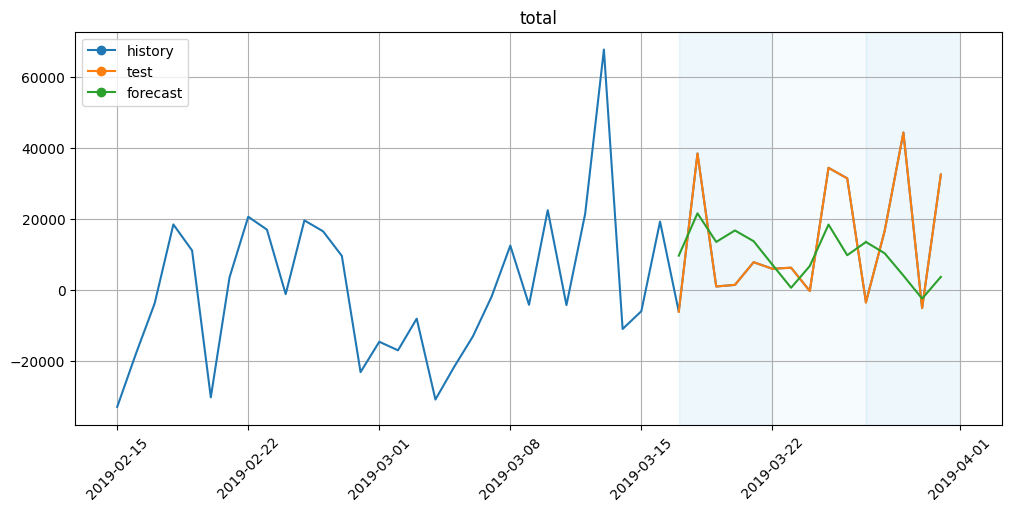

In [119]:
plot_backtest(forecast_df, hierarchical_ts.get_level_dataset(target_level="total"), history_len=30)

In [120]:
bottom_up_metrics

MAE_bottom_up
segment               
total     14185.884884

Траектория соблюдена. Качество улучшилось, МАЕ на 1500 ниже.

### Задание 6. Построение признаков (1.5 балла)

Вернемся к нашему исходному мультисегментному ряду - теперь поработаем с моделями, которые требуют построения признаков - `ARIMA` и `CatBoost`. Построим для них признаки, и попробуем при помощи них добиться улучшения качества. Из обязательного: 1) постройте графики автокорреляции и при помощи них обоснуйте выбор лаговых признаков 2) для катбуста включите в признаки результаты STL разложения. Кроме этого, подумайте на экспертном уровне, какие закономерности могут присутствовать в пополнени наличности из банкомата? Снятии? Что из этого кажется более предсказуемым, и почему? Cделайте соответствующие признаки, и снабдите их кратким комментарием.

После этого, обучите на получившихся признаках модели.

Ниже приведены импорты, которые вам точно понадобятся - к ним необходимо добавить те инструменты, которые вы дополнительно решите использовать в анализе.

In [121]:
from etna.analysis import acf_plot, stl_plot
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
from etna.models import (CatBoostPerSegmentModel, CatBoostMultiSegmentModel,
                         AutoARIMAModel)
from etna.transforms import STLTransform, LagTransform, SegmentEncoderTransform

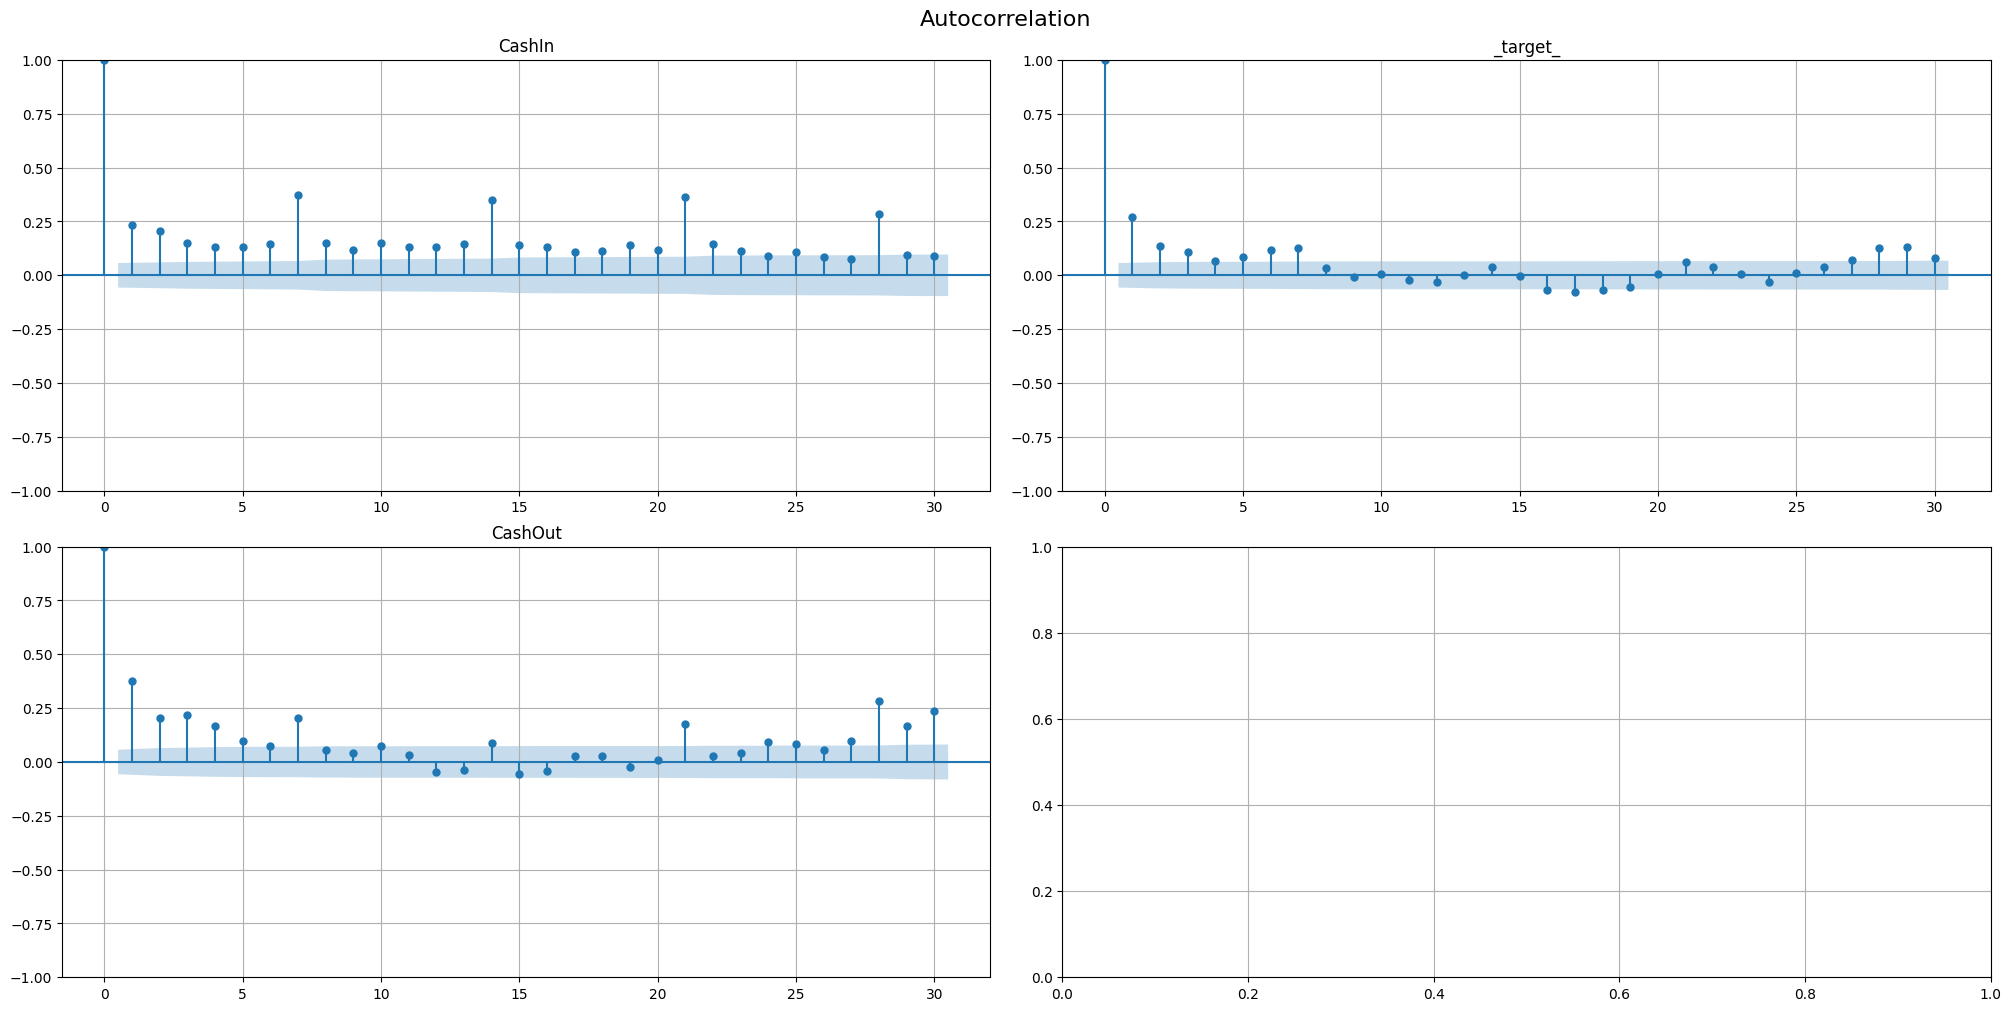

In [123]:
#YOUR CODE HERE#
acf_plot(ts, lags=30)

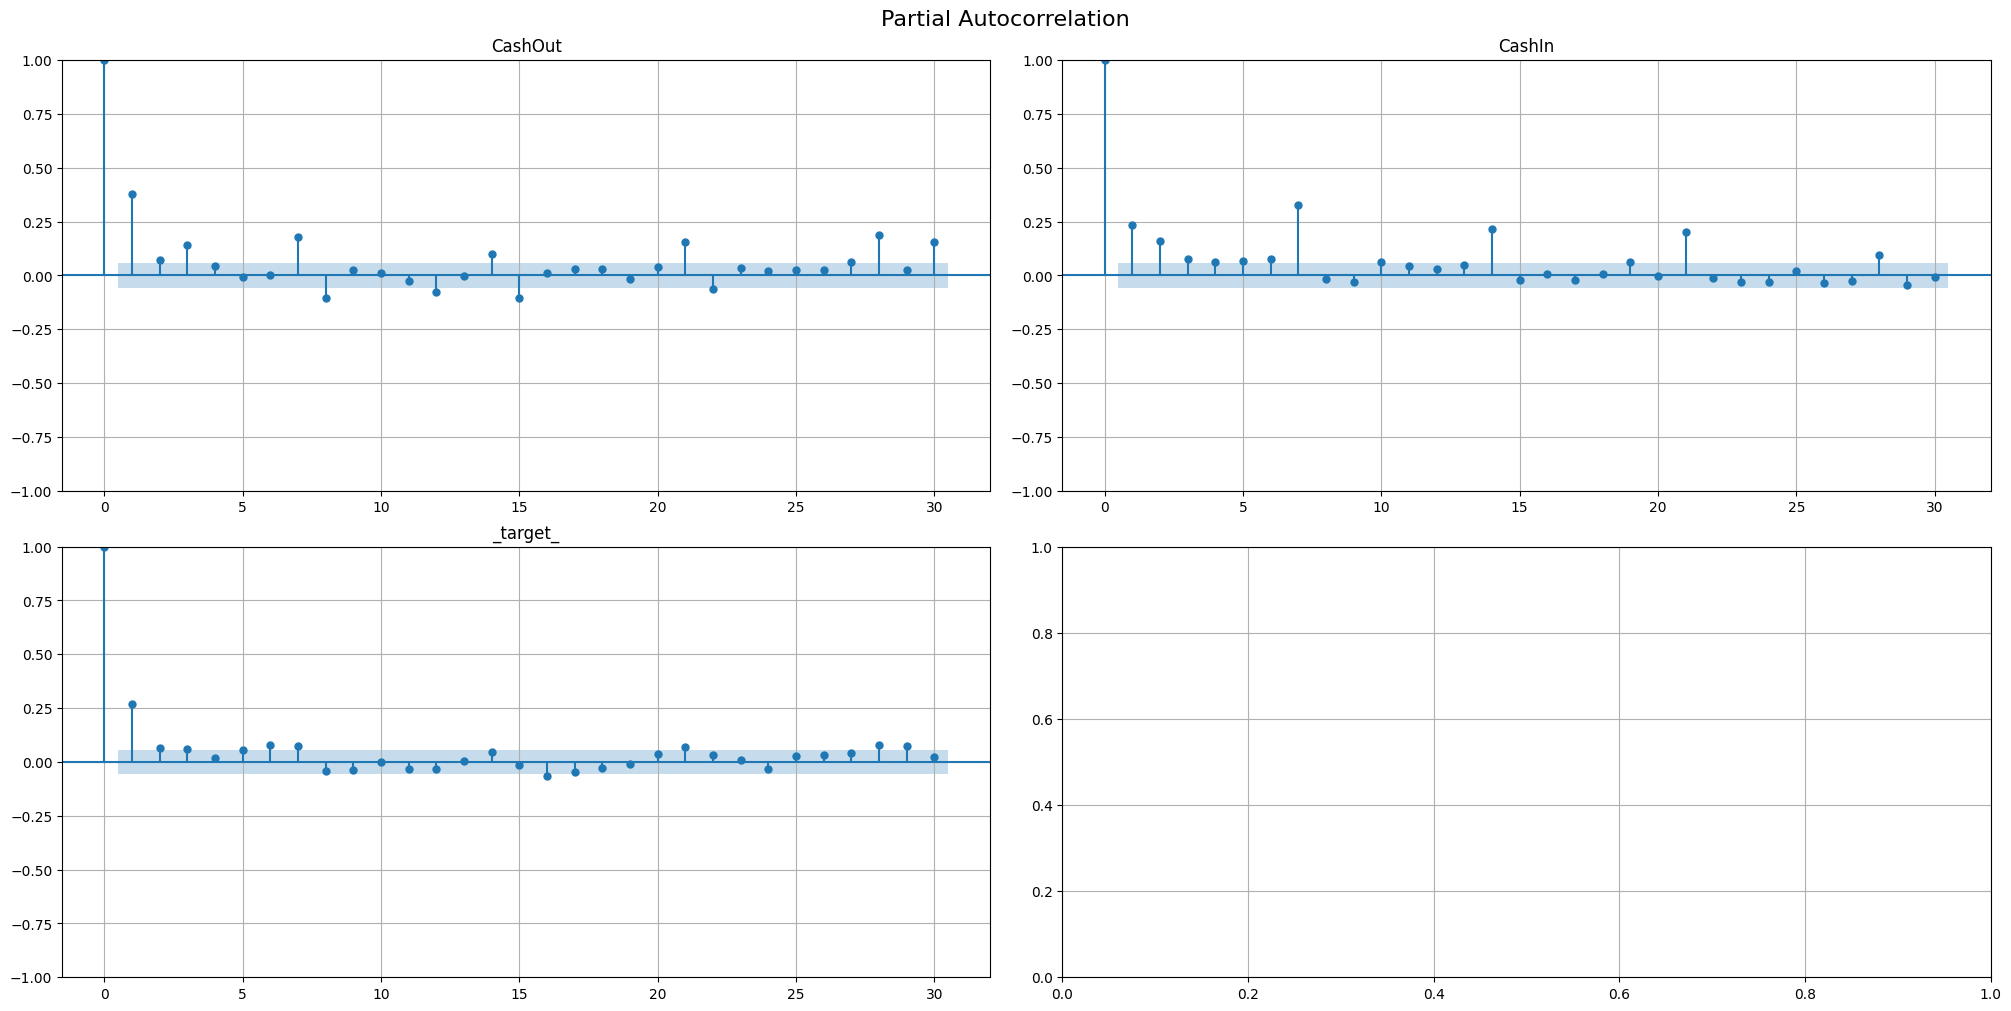

In [124]:
acf_plot(ts, partial=True, lags=30)

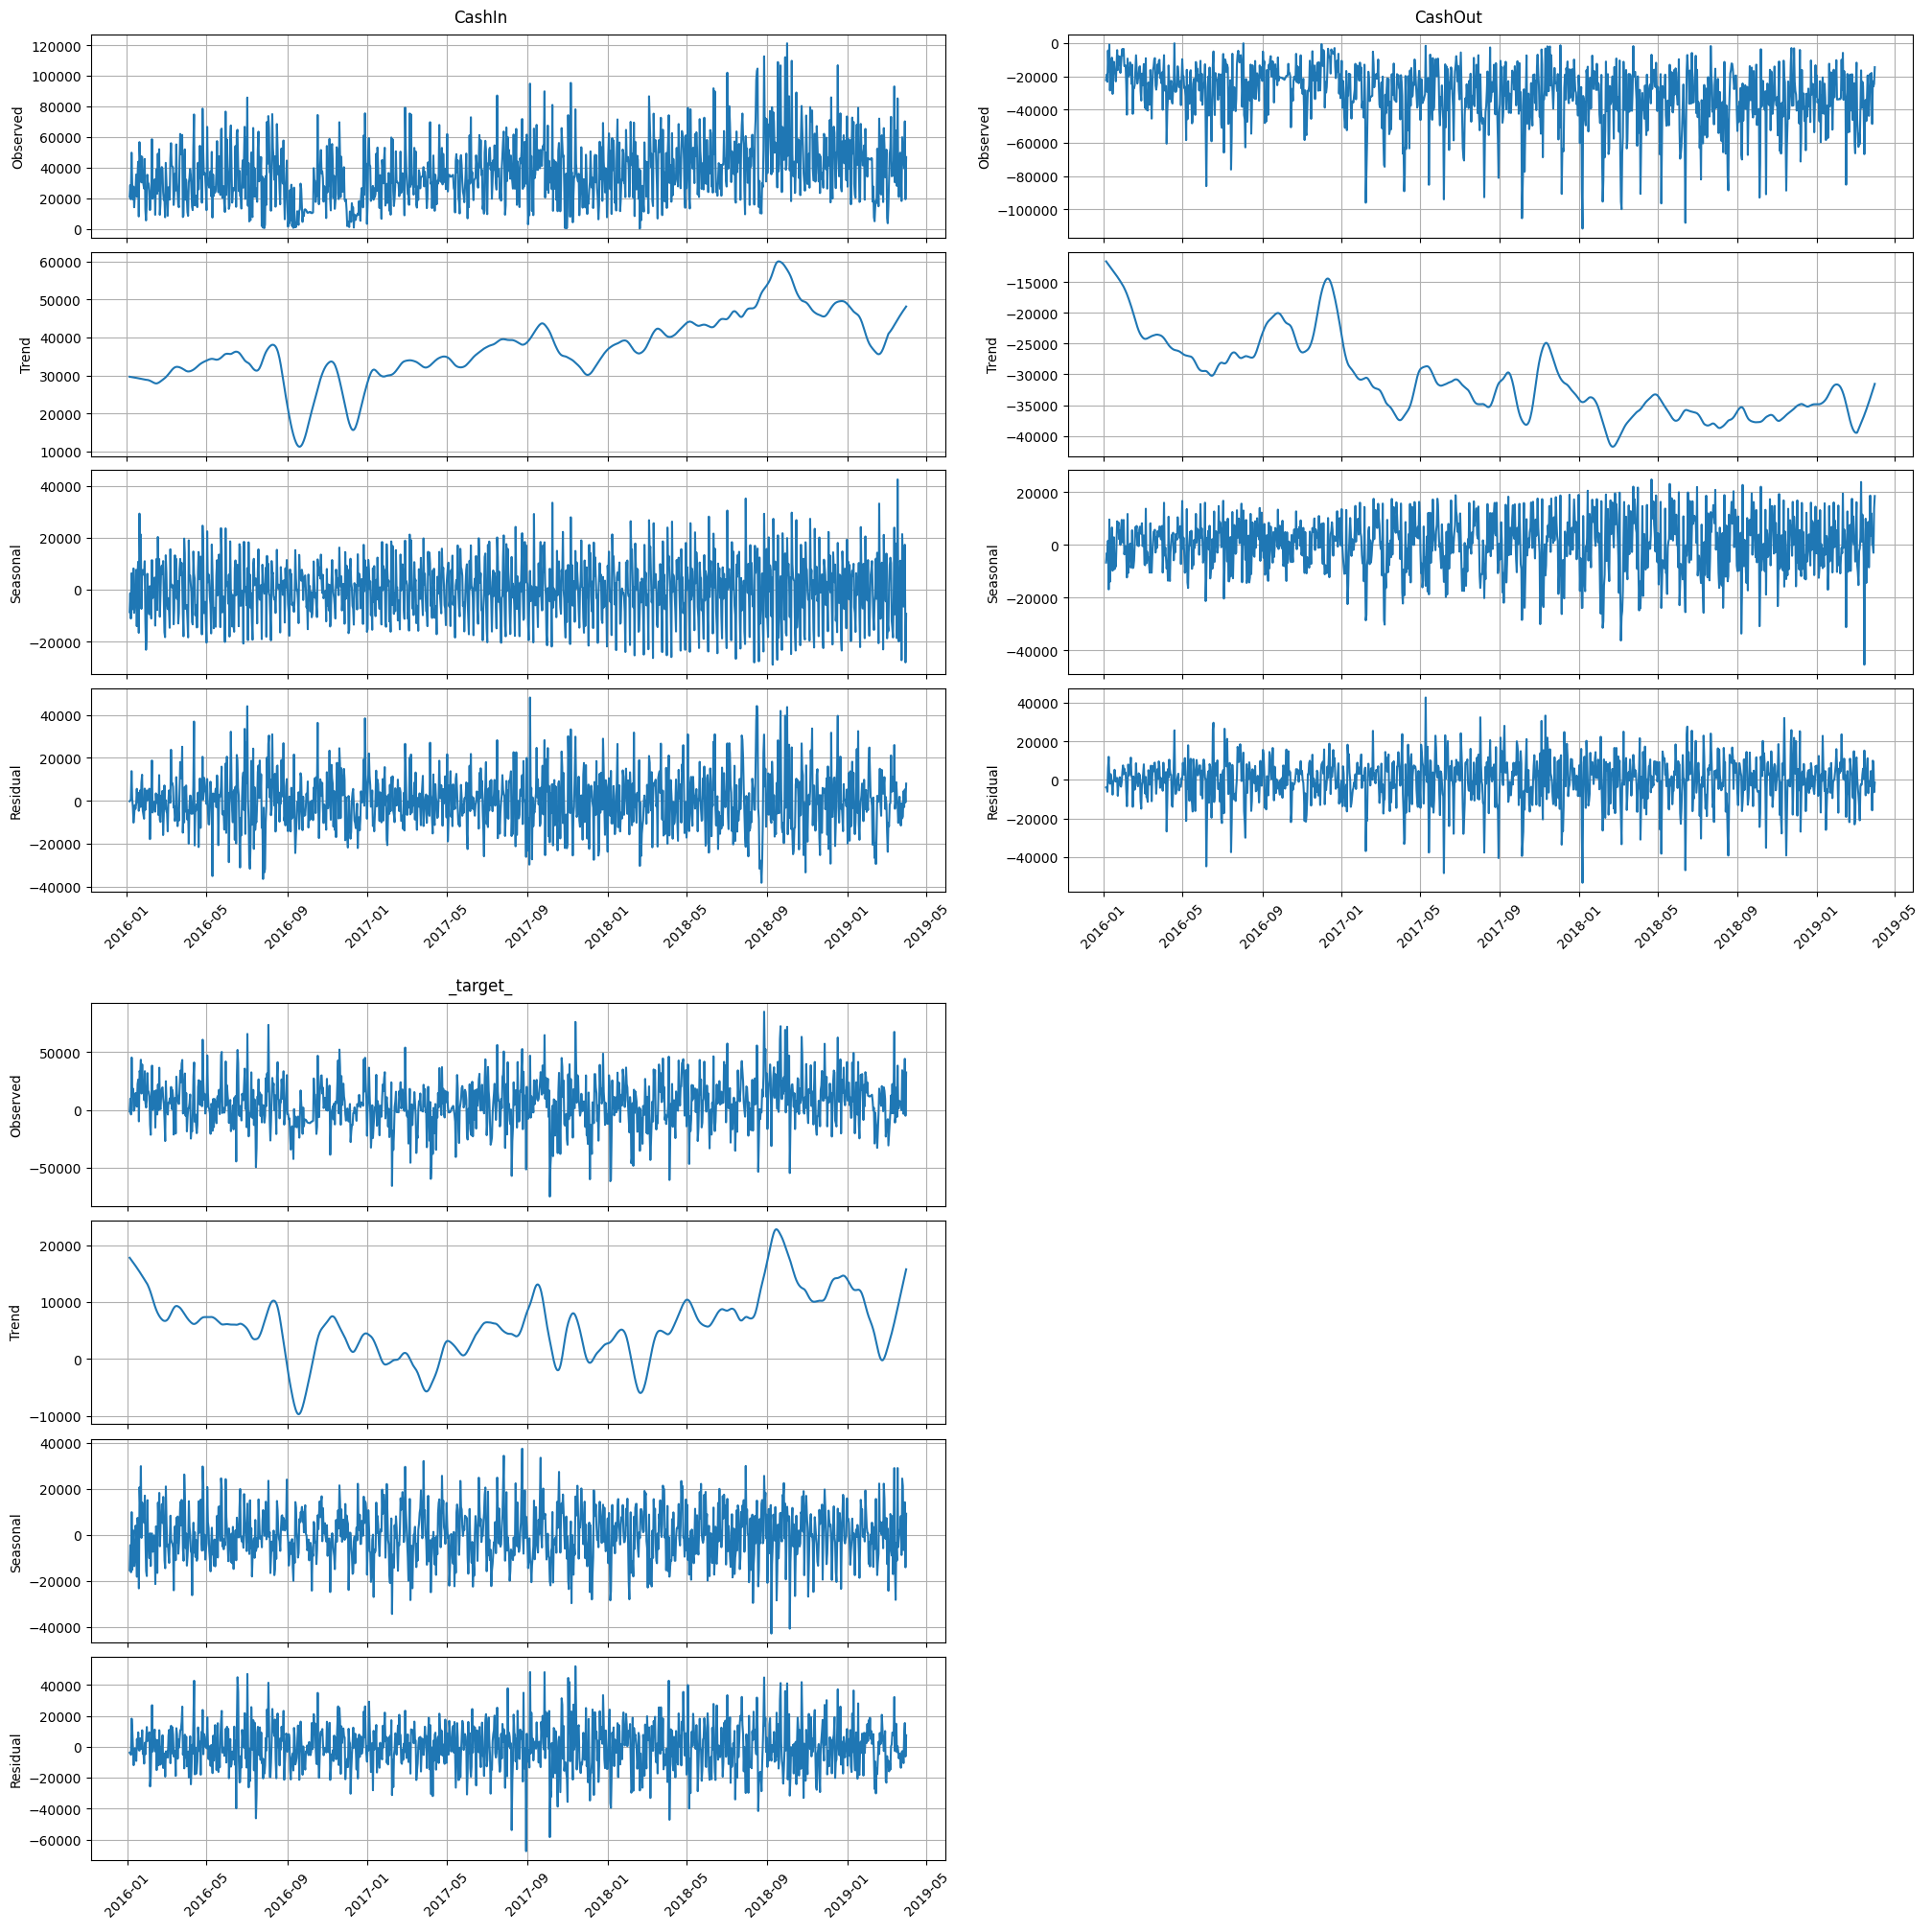

In [125]:
stl_plot(ts, period=28)

Явно видна переодичность данных. Выражена недельная сезонность. Каждые 7 лагов внаблюдается высокая автокорреляция, остальное не поддается структурированию, однако в первую неделю более выраженные корреляции, чем в остальные недели. Посмотрим на лагах 1-7.

In [198]:
pipeline_cat = Pipeline(
    transforms=[
        STLTransform(in_column="target", period=7, model="arima"),
        LagTransform(in_column="target", lags=list(range(1,8))),
        SegmentEncoderTransform()
    ],
    model=CatBoostMultiSegmentModel(),
    horizon=HORIZON
)
metrics, forecast, _ = pipeline_cat.backtest(
    ts=train_ts, metrics=[MAE(), SMAPE()], n_folds=4, aggregate_metrics=True
)
metrics

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   22.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   22.8s finished


segment           MAE       SMAPE
0    CashIn  25547.261616   52.102110
1   CashOut  14274.365740   63.178400
2  _target_  21871.079260  119.585717

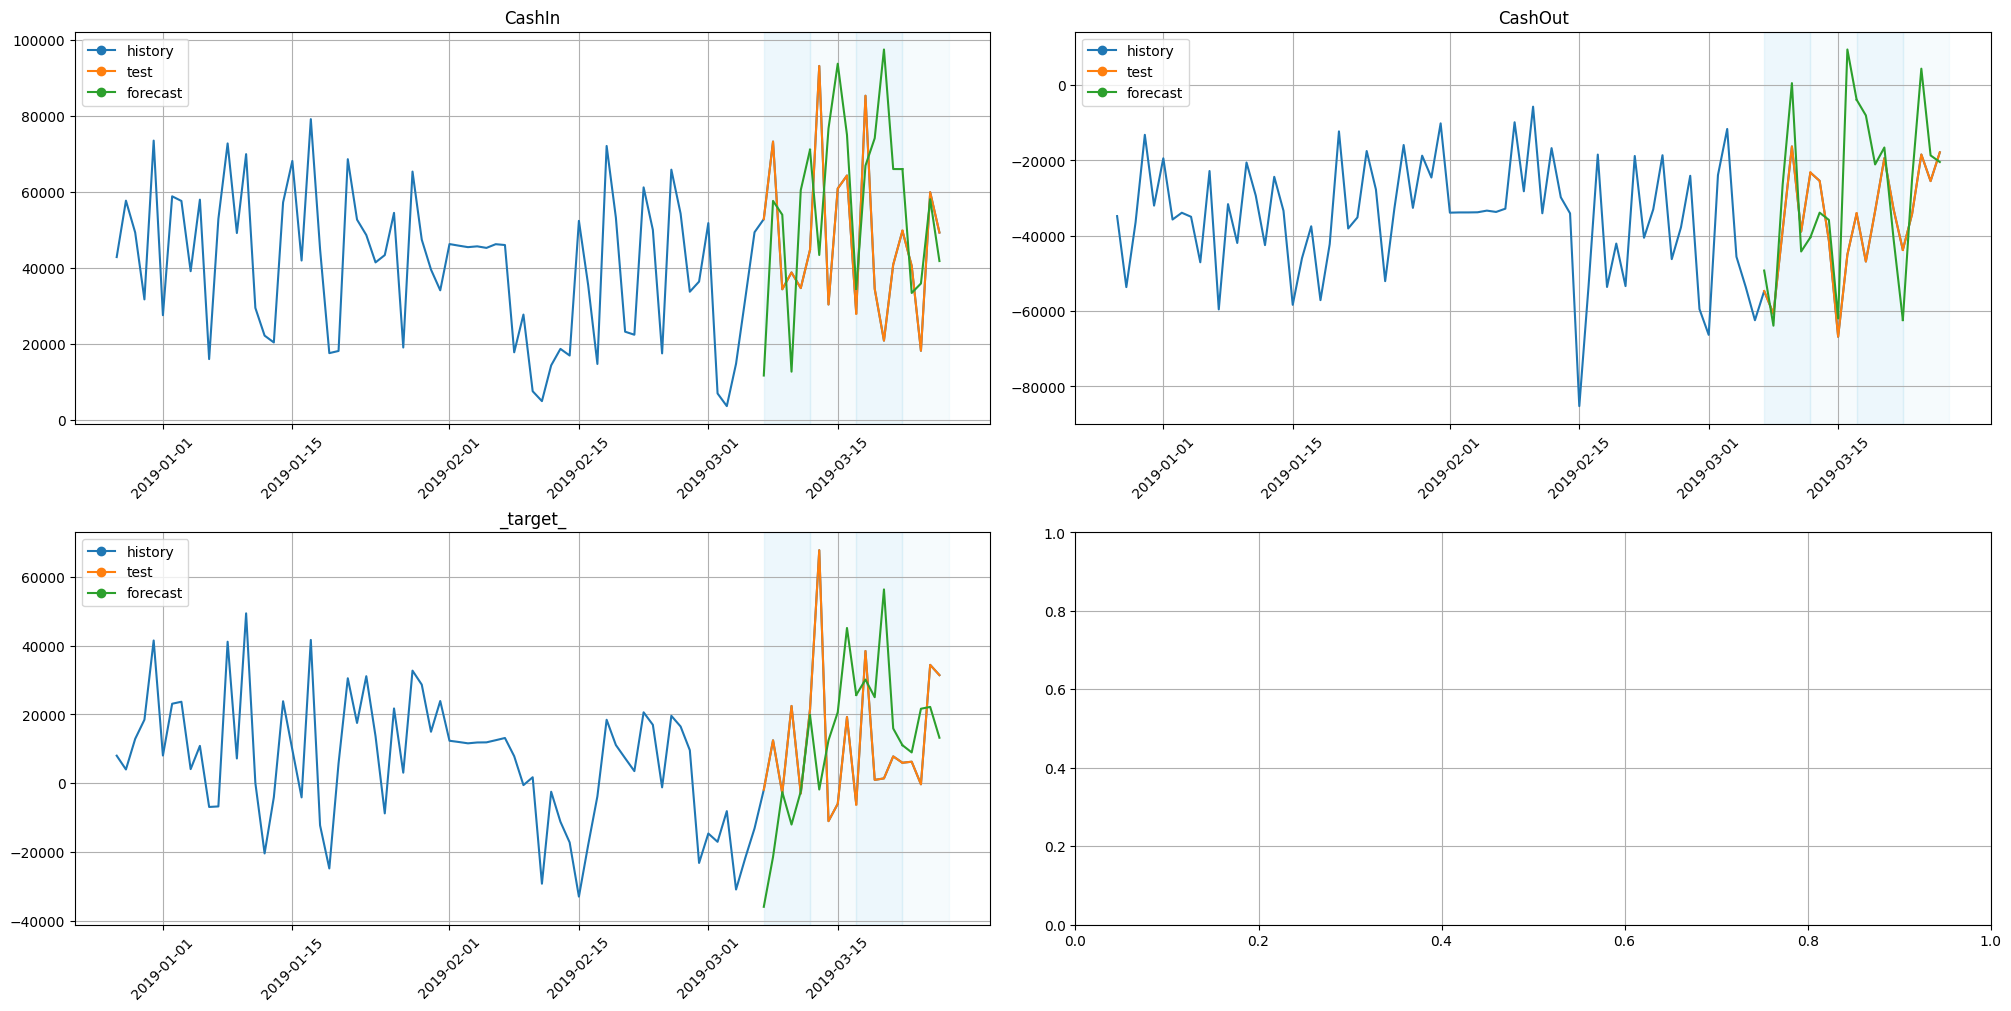

In [133]:
plot_backtest(forecast, train_ts, history_len=70)

МАЕ выросло.

Докручу еще признаки.

In [135]:
from etna.transforms import StandardScalerTransform

In [137]:
pipeline = Pipeline(
    transforms=[
        STLTransform(in_column="target", period=7, model="arima"),
        LagTransform(in_column="target", lags=list(range(1,8))),
        LinearTrendTransform(in_column="target", poly_degree=7),
        StandardScalerTransform(in_column="target", with_mean=True, mode="per-segment"),
        SegmentEncoderTransform()
    ],
    model=CatBoostMultiSegmentModel(),
    horizon=HORIZON
)
metrics, forecast, _ = pipeline.backtest(
    ts=train_ts, metrics=[MAE(), SMAPE()], n_folds=4, aggregate_metrics=True
)
metrics

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   25.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   25.8s finished


segment           MAE       SMAPE
0    CashIn  24125.311976   49.692767
1   CashOut  12913.710345   53.228831
2  _target_  22194.707672  137.248463

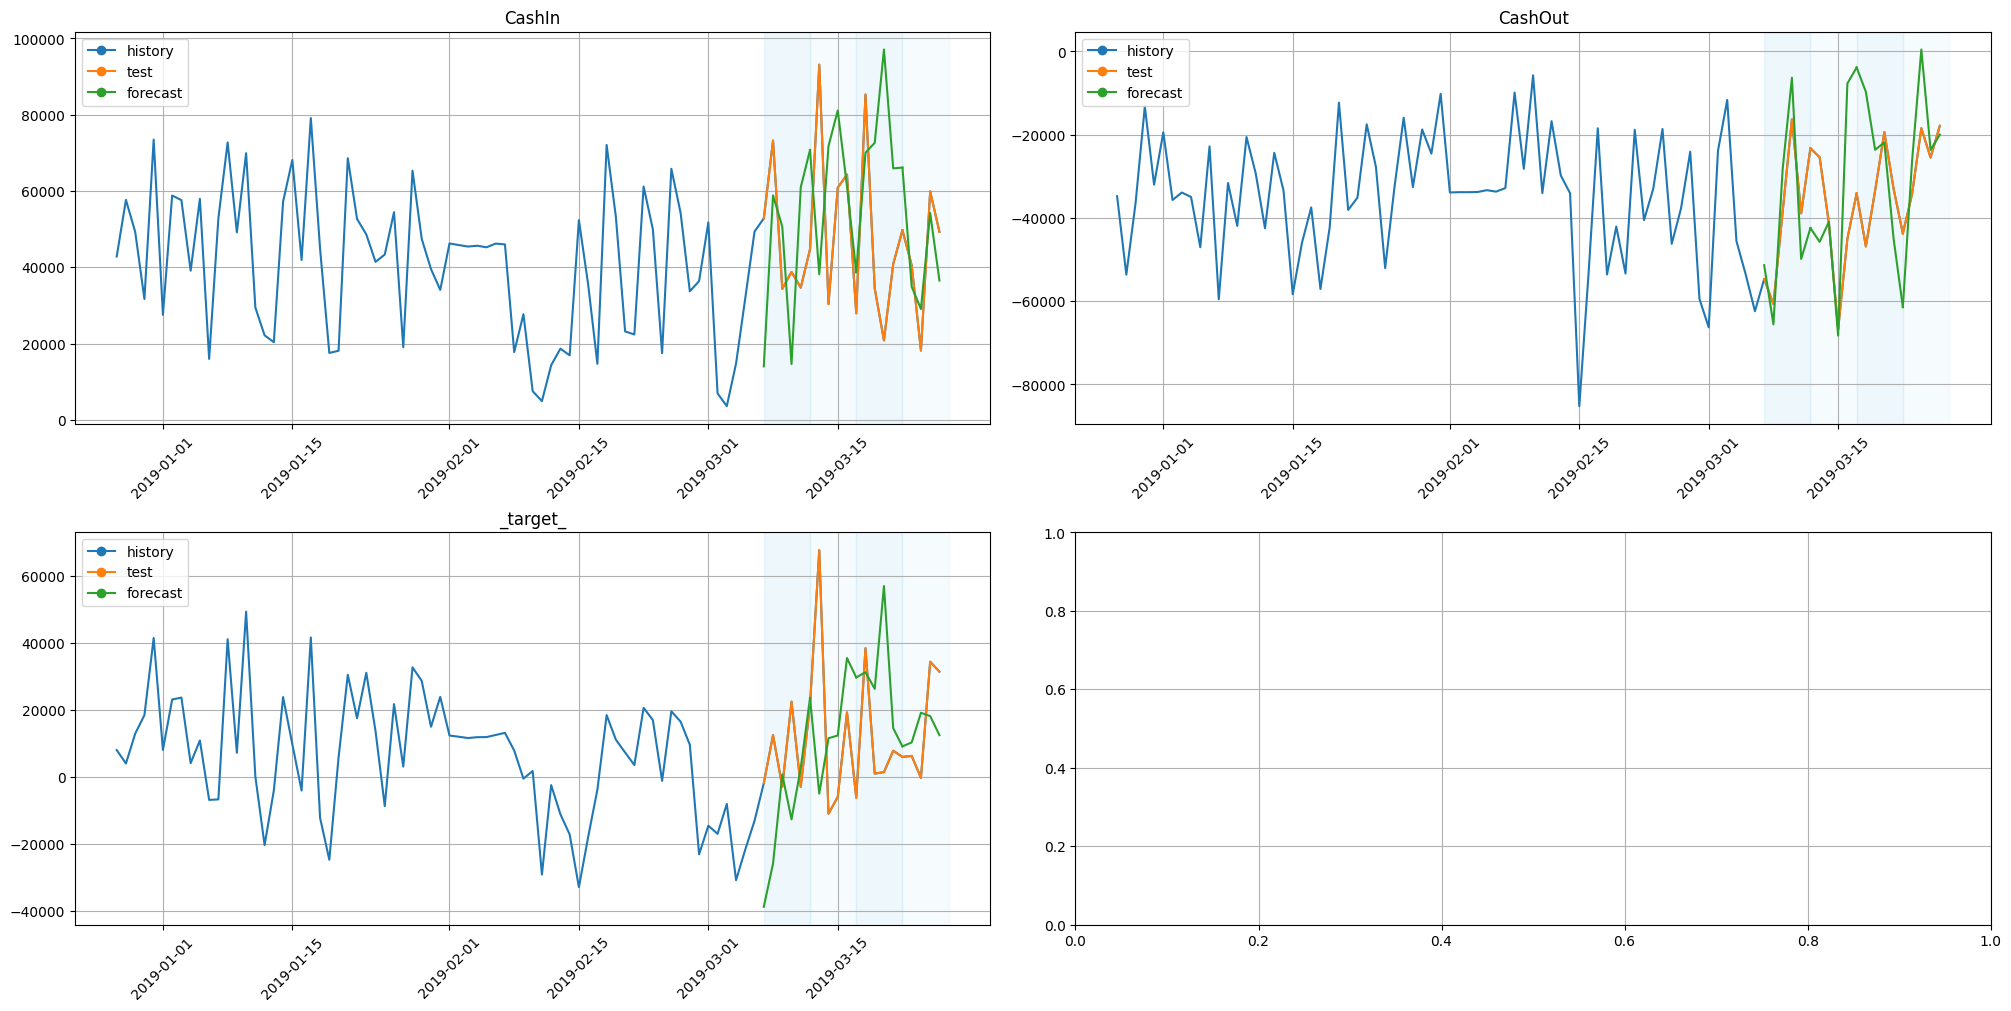

In [138]:
plot_backtest(forecast, train_ts, history_len=70)

Еще хуже. Запущу просто ариму, без катбуста.

In [217]:
pipeline = Pipeline(
    transforms=[
        LagTransform(in_column="target", lags=list(range(20,28))),
        SegmentEncoderTransform()
    ],
    model=AutoARIMAModel(),
    horizon=HORIZON
)
metrics, forecast, _ = pipeline.backtest(
    ts=train_ts, metrics=[MAE(), SMAPE()], n_folds=4, aggregate_metrics=True, n_jobs=-1
)
metrics

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  4.7min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  9.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  9.2min finished


segment           MAE       SMAPE
0    CashIn  16056.829684   34.383230
1   CashOut  10928.193420   31.697875
2  _target_  14692.542082  146.565005

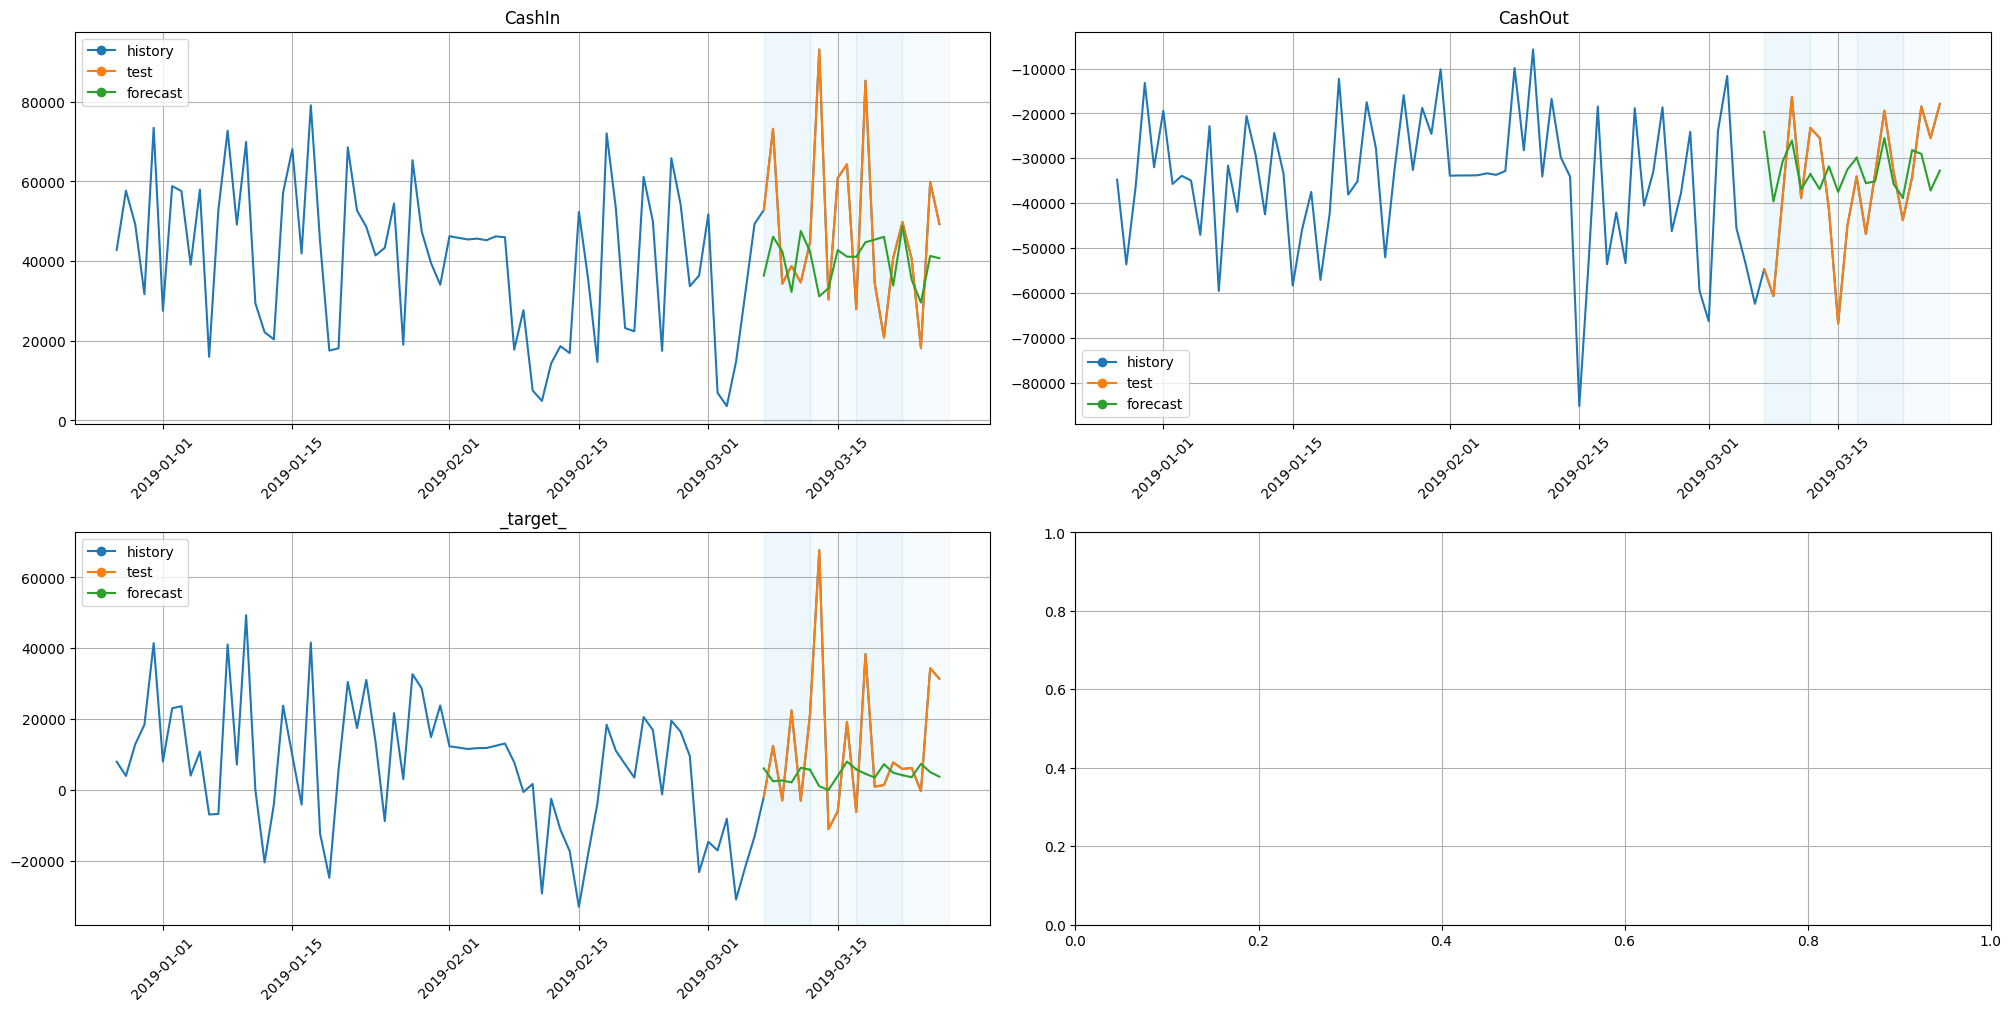

In [218]:
plot_backtest(forecast, train_ts, history_len=70)

Самостоятельная арима дает результат намного лучше катбуста с stl на ариме.

### Задание 7. Стратегии прогнозирования (1.25 балла)

Как нам известно по семинарским занятиям, при построении прогноза на горизонте дальше следующего наблюдения перед нами встает задача определиться со стратегией генерации прогноза. Попробуйте разные стратегии на нашем горизонте из 5 дней (прямая, рекурсивная, смешанная dirrec). Какая стратегия в совокупности с какой моделью дает лучший результат?

Учитывайте особенности, которые некоторые стратегии могут накладывать на признаки (в частности, на лаговые переменные).

При необходимости, в смешанном методе пользуйтесь упрощенной схемой спецификации моделей/преобразований.

In [139]:
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines
from etna.ensembles import DirectEnsemble

In [199]:
print('Прямой метод')
model = CatBoostPerSegmentModel()
transforms = [
    LinearTrendTransform(in_column="target"),
    LagTransform(
        in_column="target",
        lags=list(range(HORIZON, HORIZON + 7)),
        out_column="target_lag",
    ),
]

pipeline_1 = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

metrics_pipeline_df, forecast_pipeline_df, _ = pipeline_1.backtest(
    ts=train_ts, metrics=[MAE(), SMAPE()], n_folds=4, aggregate_metrics=True
)

metrics_pipeline_df

Прямой метод


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   38.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   38.6s finished


segment           MAE       SMAPE
0    CashIn  15829.732153   33.470633
1   CashOut  11269.782615   32.793202
2  _target_  15524.423073  143.338864

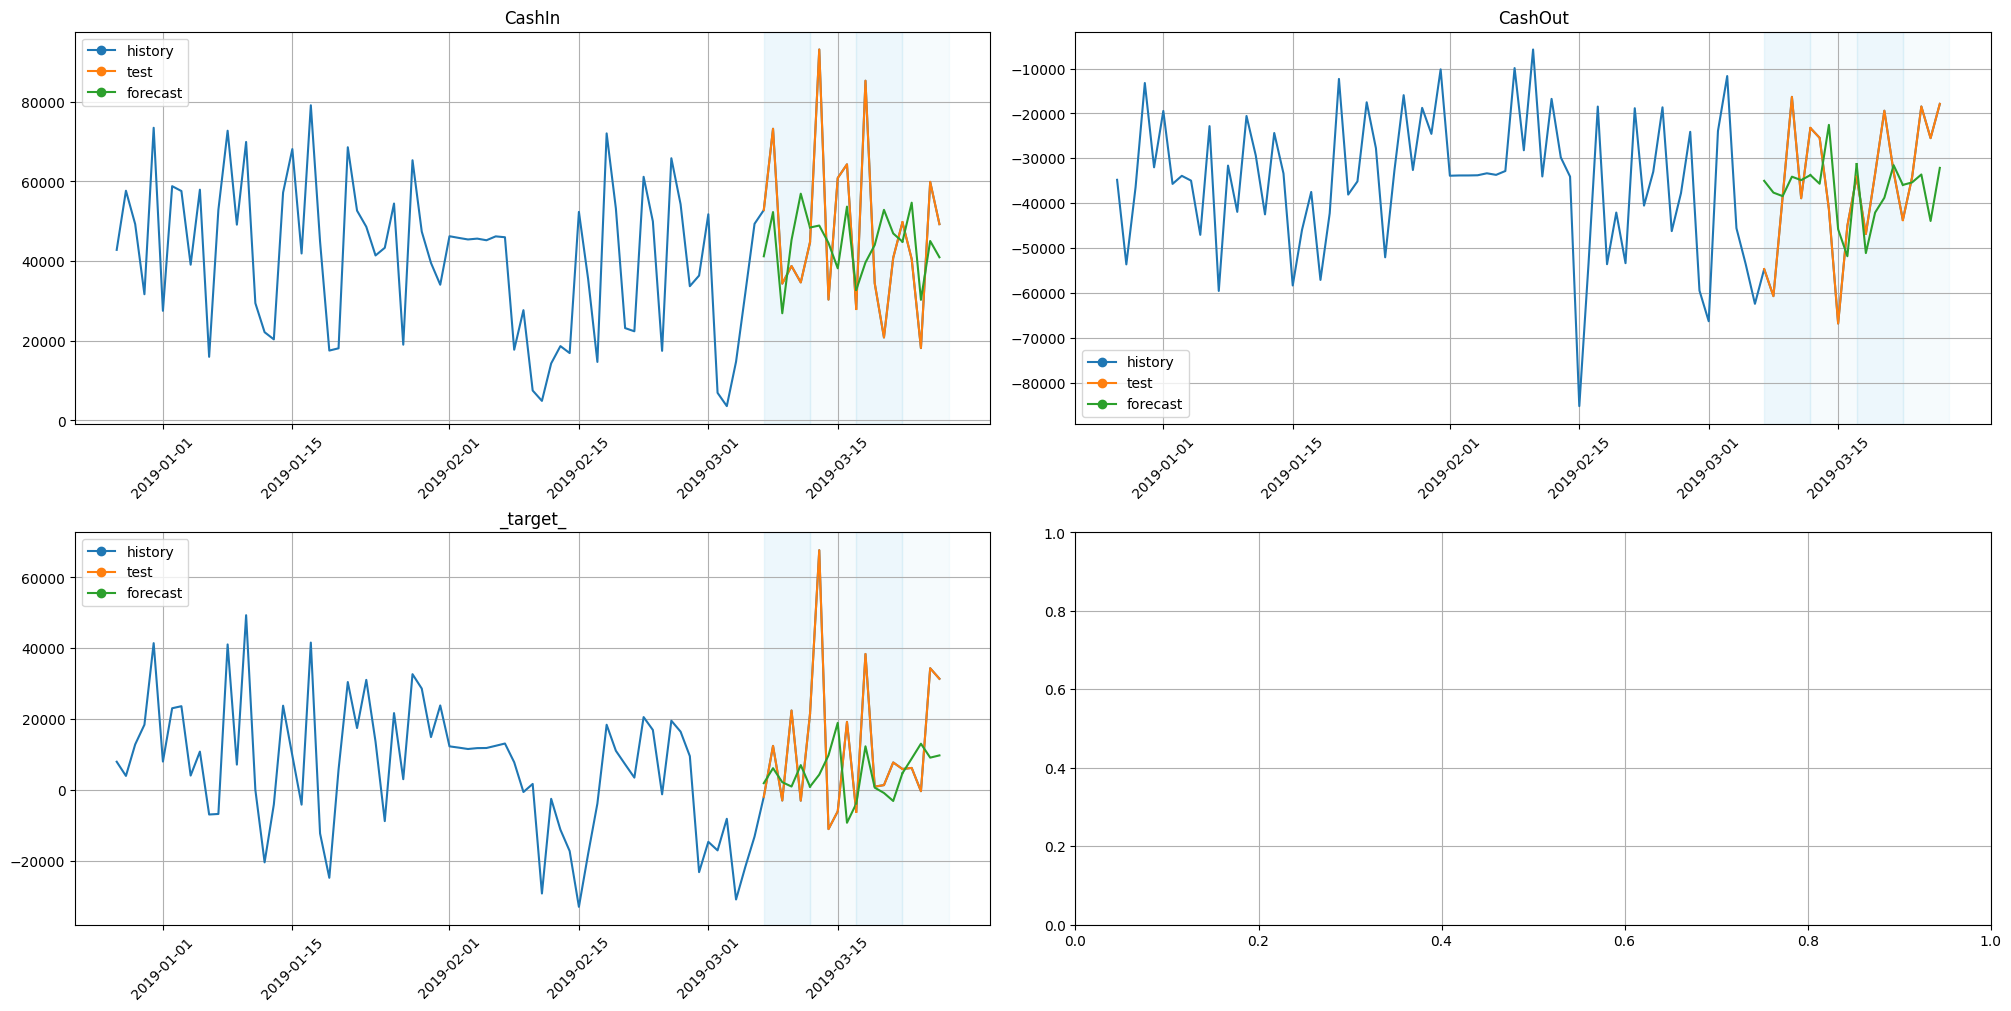

In [152]:
plot_backtest(forecast_pipeline_df, train_ts, history_len=70)

In [155]:
print("рекурсивный")
model = CatBoostPerSegmentModel()

transforms = [
    LinearTrendTransform(in_column="target"),
    LagTransform(
        in_column="target",
        lags=[i for i in range(1, 1 + 7)],
        out_column="target_lag",
    ),
]

autoregressivepipeline = AutoRegressivePipeline(
    model=model, transforms=transforms, horizon=HORIZON, step=1
)

metrics_recursive_df, forecast_recursive_df, _ = autoregressivepipeline.backtest(
    ts=train_ts, metrics=[MAE(), SMAPE()], n_folds=4, aggregate_metrics=True
)

metrics_recursive_df

рекурсивный


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   47.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   47.2s finished


segment           MAE       SMAPE
0    CashIn  13262.593572   28.436594
1   CashOut   9632.949051   28.225393
2  _target_  17389.902312  144.892747

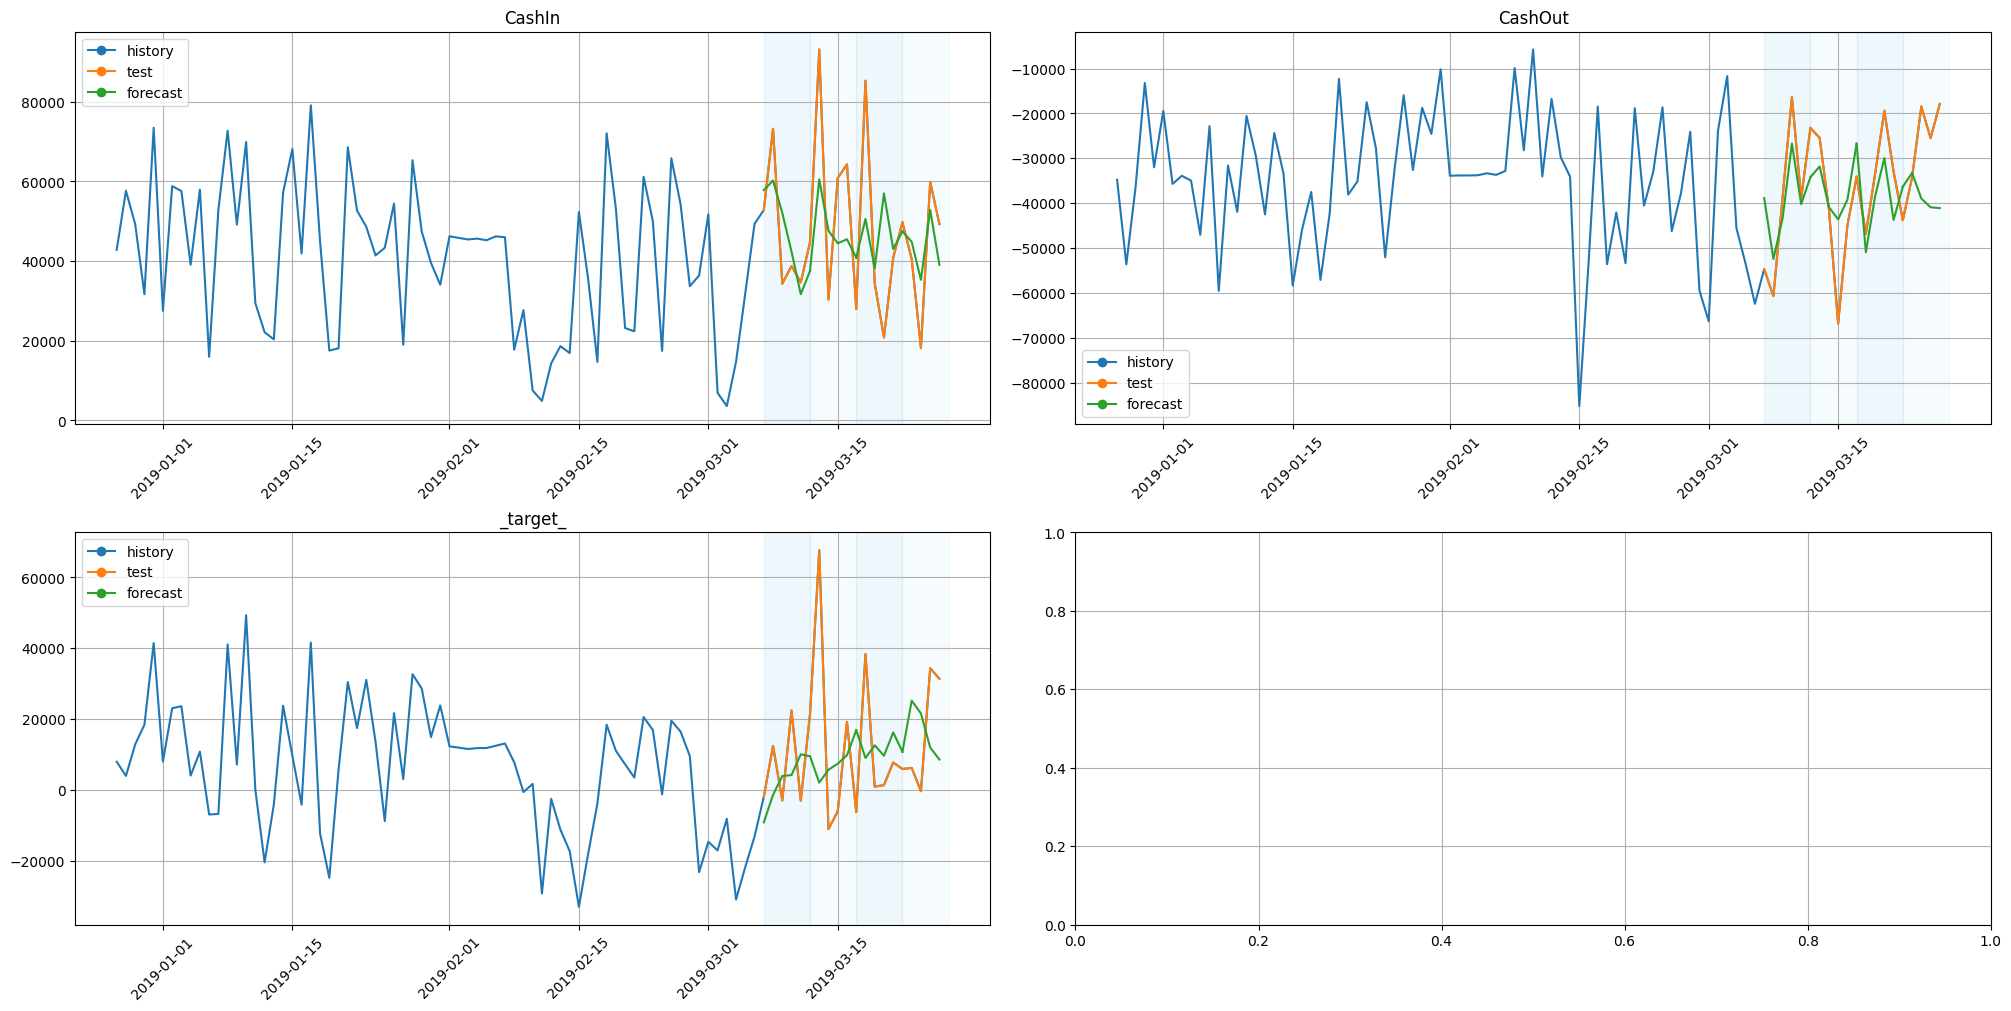

In [154]:
plot_backtest(forecast_recursive_df, train_ts, history_len=70)

In [156]:
print("dirrec")
horizons = [5, 12]

model_1 = CatBoostPerSegmentModel()
transforms_1 = [
    LinearTrendTransform(in_column="target"),
    LagTransform(
        in_column="target",
        lags=[i for i in range(horizons[0], horizons[0] + 7)],
        out_column="target_lag",
    ),
]
pipeline_1 = Pipeline(model=model_1, transforms=transforms_1, horizon=horizons[0])


model_2 = CatBoostPerSegmentModel()
transforms_2 = [
    LinearTrendTransform(in_column="target"),
    LagTransform(
        in_column="target",
        lags=[i for i in range(horizons[1], horizons[1] + 7)],
        out_column="target_lag",
    ),
]

pipeline_2 = Pipeline(model=model_2, transforms=transforms_2, horizon=horizons[1])

ensemble = DirectEnsemble(pipelines=[pipeline_1, pipeline_2])

metrics_ensemble_df, forecast_ensemble_df, _ = ensemble.backtest(
    ts=train_ts, metrics=[MAE(), SMAPE()], n_folds=4, aggregate_metrics=True
)

metrics_ensemble_df

dirrec


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   1

segment           MAE       SMAPE
0    CashIn  20944.380317   53.946003
1   CashOut  14034.805958   40.445878
2  _target_  15937.616338  149.037526

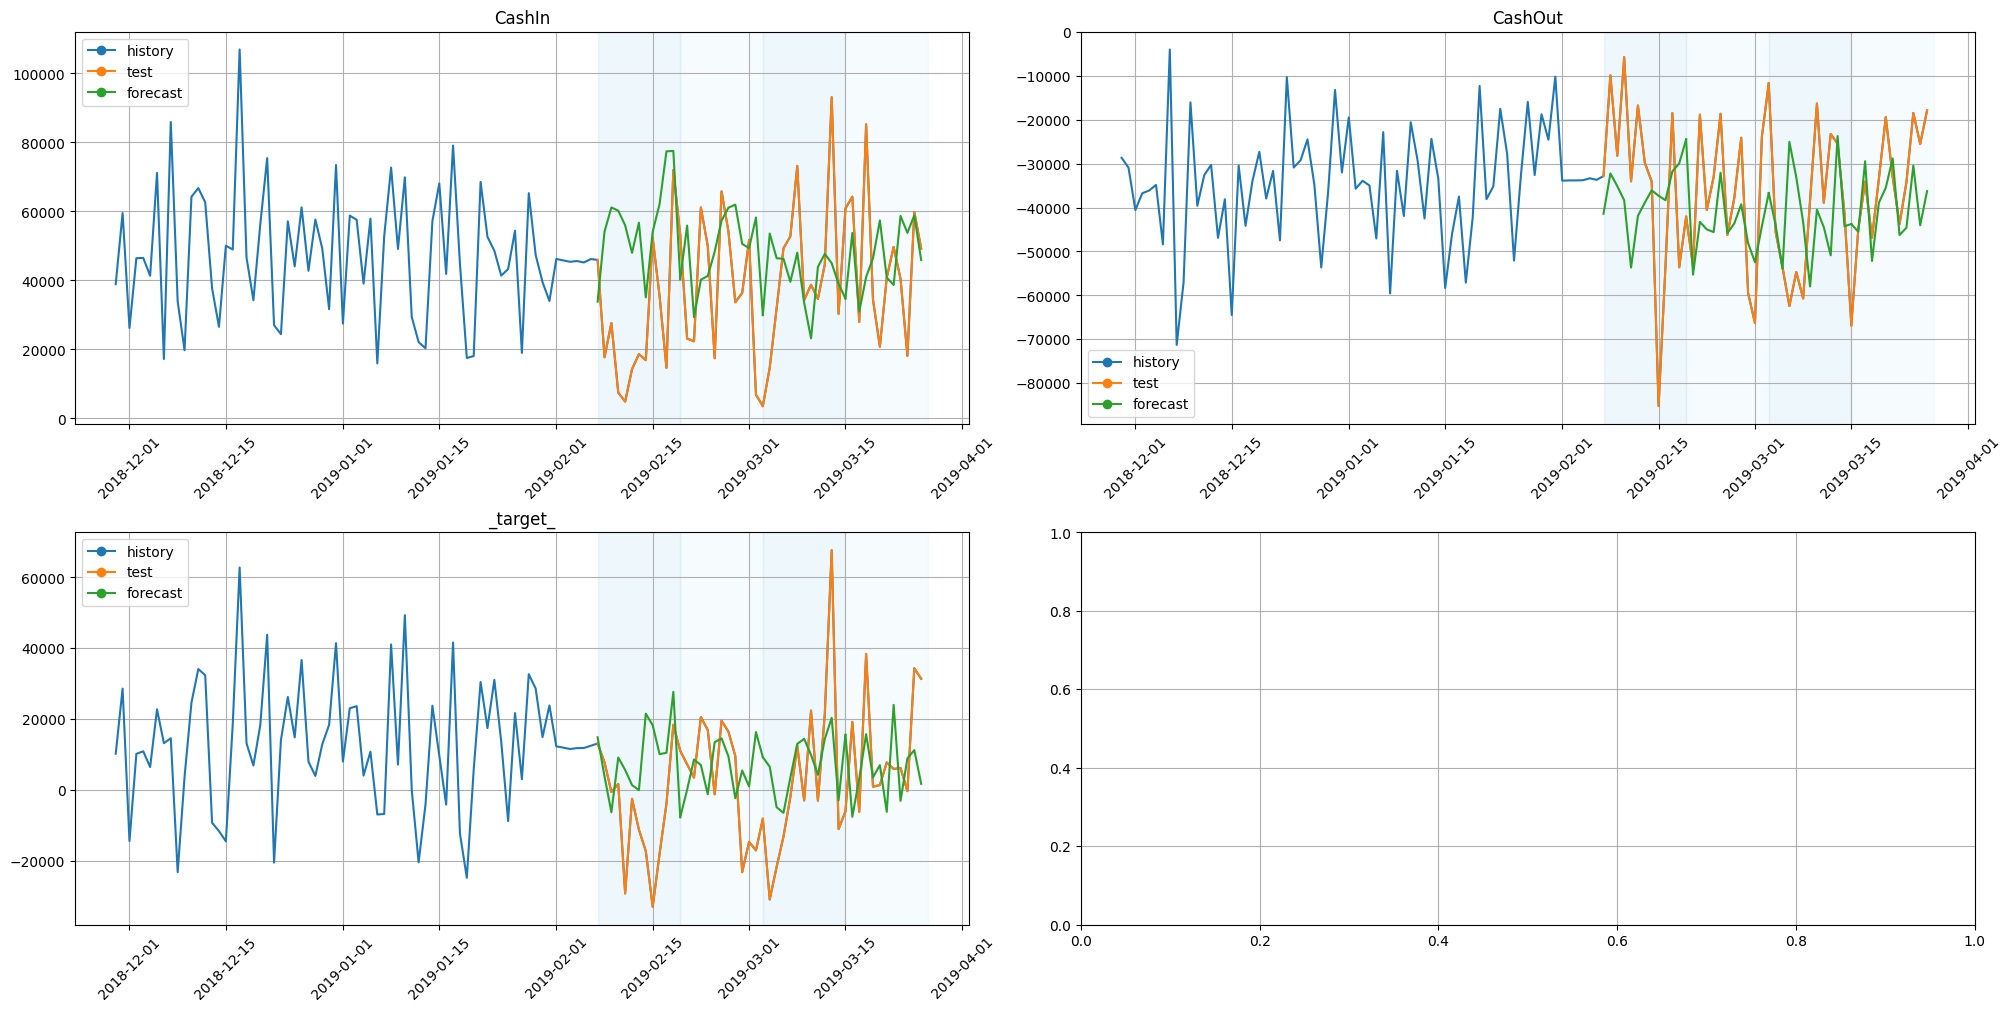

In [157]:
plot_backtest(forecast_ensemble_df, train_ts, history_len=70)

Прямой метод дает наилучшее качество.

### Задание 8. Ансамбли (1.25 балла)

Чтобы не выбирать лучшую модель, мы можем использовать преимущества каждой - давайте объединим все наши наработки в ансамбль. Попробуйте различные опции ансамблирования, и выберите ту, которая работает лучше всего (не забывайте, что внутри каждого ансамбля у нас тоже есть параметры, которые мы можем варьировать - веса в voting, включаемые признаки в stacking).

In [158]:
from etna.ensembles import StackingEnsemble, VotingEnsemble

In [200]:
pipelines = [pipeline_prophet, pipeline_cat, pipeline_1, autoregressivepipeline]

In [201]:
#YOUR CODE HERE#
stacking_ensemble_unfeatured = StackingEnsemble(
    pipelines=pipelines, n_folds=10, n_jobs=4
)

In [209]:
stacking_ensamble_metrics = stacking_ensemble_unfeatured.backtest(
    ts=train_ts,
    metrics=[MAE(), SMAPE()],
    n_folds=4,
    aggregate_metrics=True,
    n_jobs=4,
)

[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2f4anepr/76hbq9ac.json
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2f4anepr/s7pmcis4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46152', 'data', 'file=/tmp/tmp2f4anepr/76hbq9ac.json', 'init=/tmp/tmp2f4anepr/s7pmcis4.json', 'output', 'file=/tmp/tmpnlriz5vc/prophet_model-20230513225553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:55:53 - cmdstanpy - INFO - C

In [219]:
stacking_ensamble_metrics[0]

segment           MAE       SMAPE
0    CashIn  15223.018472   33.261861
1   CashOut  10843.605528   31.156498
2  _target_  15024.627387  139.598005

In [213]:
voting_ensemble = VotingEnsemble(pipelines=pipelines, n_jobs=4)

voting_ensamble_metrics = voting_ensemble.backtest(
    ts=train_ts,
    metrics=[MAE(), SMAPE()],
    n_folds=4,
    aggregate_metrics=True,
    n_jobs=2,
)

[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2f4anepr/e95uojrq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2f4anepr/lmjwxpxt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55165', 'data', 'file=/tmp/tmp2f4anepr/e95uojrq.json', 'init=/tmp/tmp2f4anepr/lmjwxpxt.json', 'output', 'file=/tmp/tmp8hrinvn7/prophet_model-20230513231508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:15:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:

In [214]:
voting_ensamble_metrics[0]

segment           MAE       SMAPE
0    CashIn  14923.896782   31.309735
1   CashOut   8568.894739   25.622473
2  _target_  15844.661823  136.007055

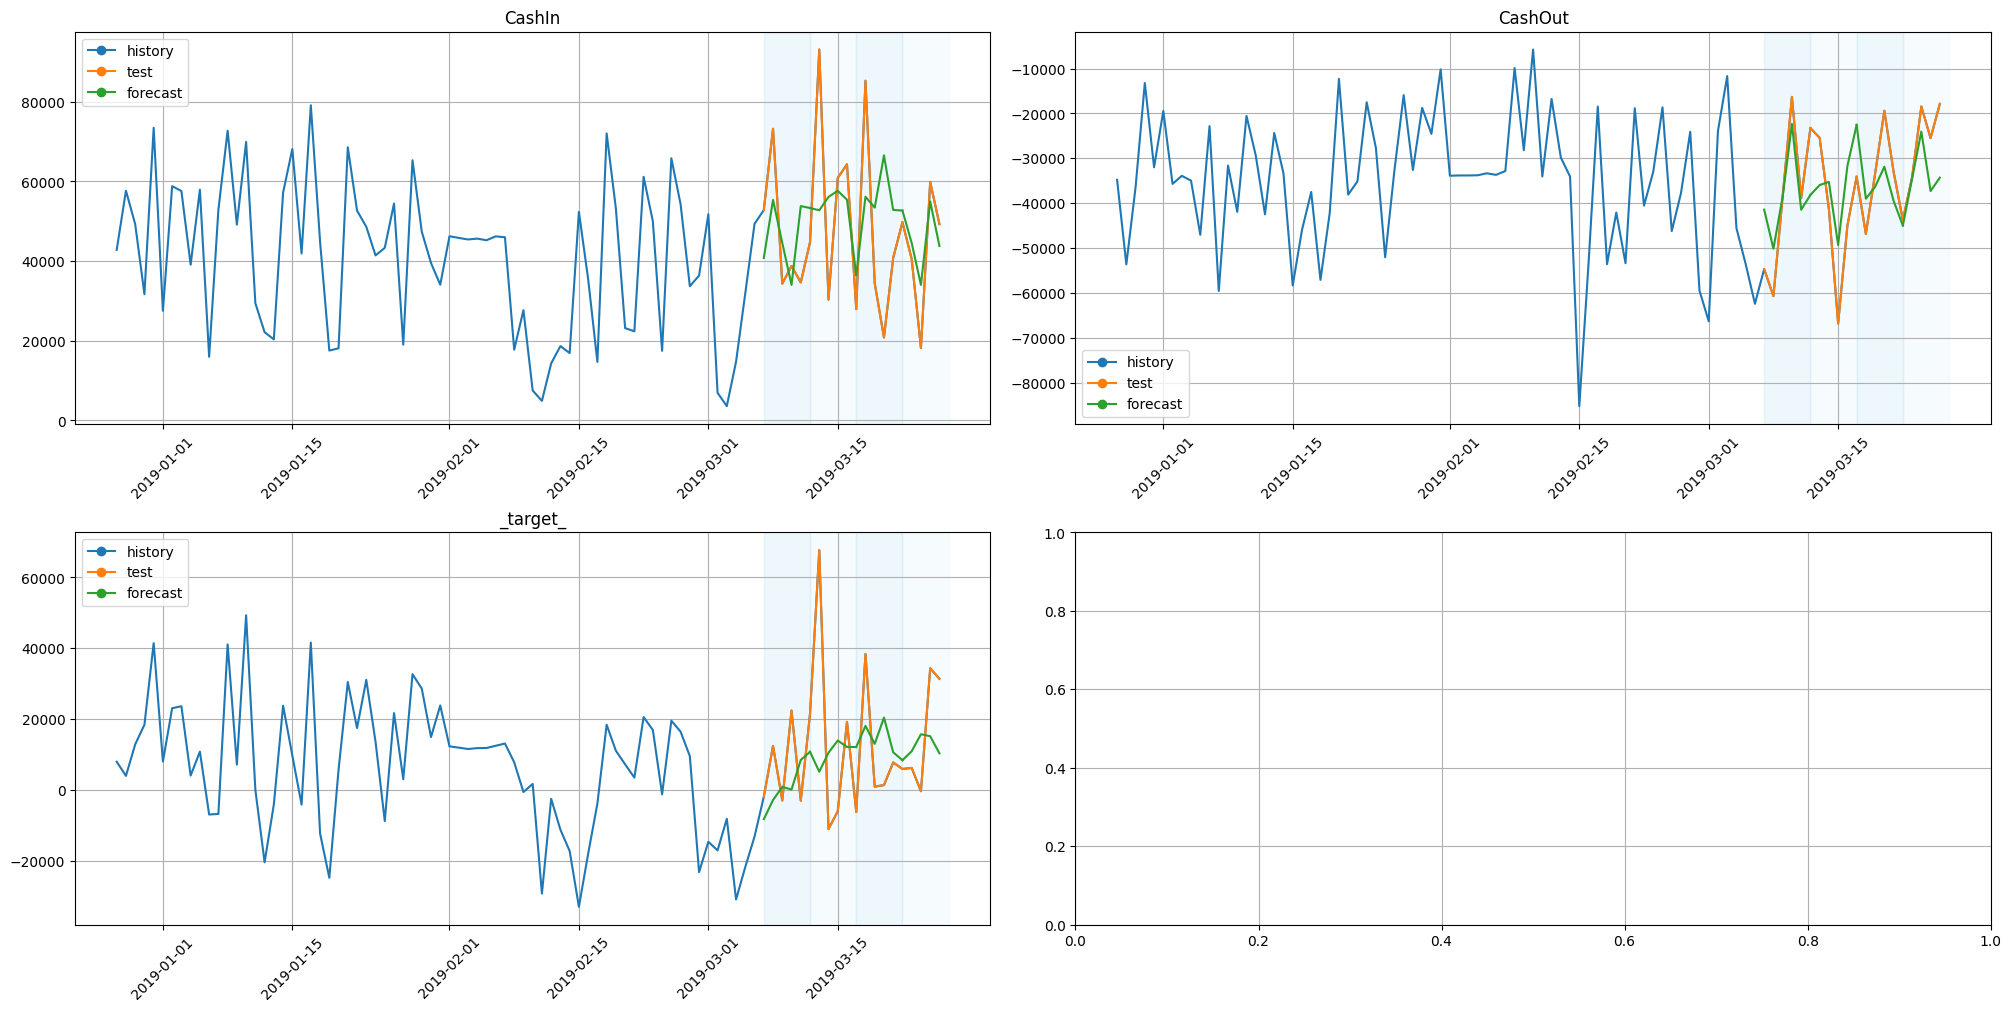

In [215]:
plot_backtest(voting_ensamble_metrics[1], train_ts, history_len=70)

In [206]:
voting_ensemble = VotingEnsemble(pipelines=pipelines, weights=[2, 5, 5, 2], n_jobs=4)

voting_ensamble_metrics = voting_ensemble.backtest(
    ts=train_ts,
    metrics=[MAE(), SMAPE()],
    n_folds=4,
    aggregate_metrics=True,
    n_jobs=2,
)

[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2f4anepr/3jg9t4n_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2f4anepr/_zgkd9pw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70124', 'data', 'file=/tmp/tmp2f4anepr/3jg9t4n_.json', 'init=/tmp/tmp2f4anepr/_zgkd9pw.json', 'output', 'file=/tmp/tmpdxx9nc7c/prophet_model-20230513225105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:51:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:

(    segment           MAE       SMAPE
 0    CashIn  15940.250901   33.272418
 1   CashOut   8415.781407   24.959753
 2  _target_  16119.842096  134.956520,
 segment         CashIn                   CashOut                  _target_  \
 feature    fold_number        target fold_number        target fold_number   
 timestamp                                                                    
 2019-03-07           0  34605.591897           0 -41730.101712           0   
 2019-03-08           0  55178.388873           0 -50409.877068           0   
 2019-03-09           0  42787.977497           0 -35913.045026           0   
 2019-03-10           0  31856.035450           0 -19965.128461           0   
 2019-03-11           0  55885.562657           0 -40626.538382           0   
 2019-03-12           1  56071.083171           1 -37697.588340           1   
 2019-03-13           1  49910.908760           1 -35449.076408           1   
 2019-03-14           1  58028.354895           1 -32

In [210]:
voting_ensamble_metrics[0]

segment           MAE       SMAPE
0    CashIn  15940.250901   33.272418
1   CashOut   8415.781407   24.959753
2  _target_  16119.842096  134.956520

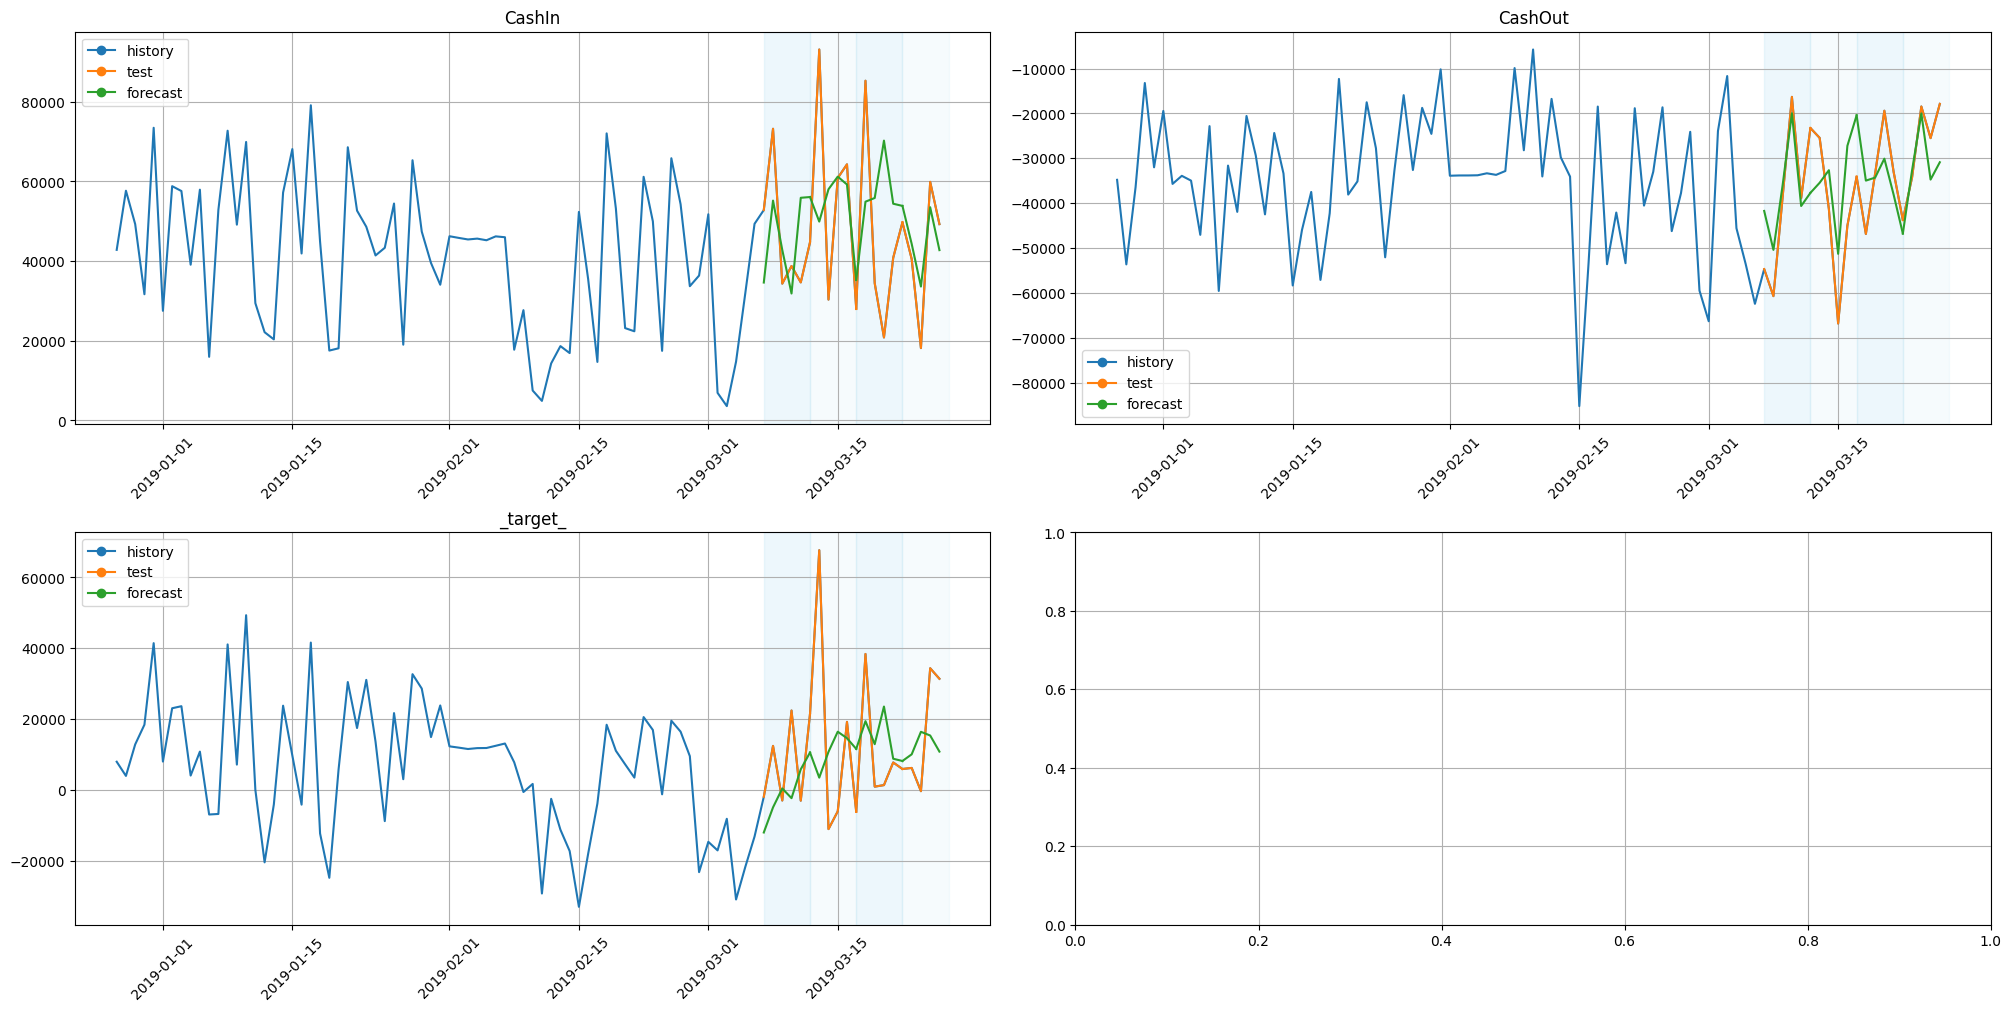

In [211]:
plot_backtest(voting_ensamble_metrics[1], train_ts, history_len=70)

Совокупность моделей дает неплохое качество. Еще лучше оно будет с правильным подбором весов.
Итого: катбуст был хорош, арима классно работает самостоятельно. Прямой метод эффективно работает. Ансамбли позволяют взять от моделей максимум возможностей, но для этого нужно точно подобрать веса. Иерархический ряд с первого раза без подбора выдал наилучшее качество.
Результаты предсказаний отрисованы на графиках и легко интерпретируются. Модели удается в точности повторить некоторые интервалы или хотя бы приблизиться к ним. Модели обучились успешно и постарались поймать моменты увеличения и уменьшения предсказываемых переменных. 

### Задание 9*. Трансформер (бонус 2 балла)

Для желающих протестировать мощь трансформенных моделей предлагается "завести" модель из второго семинара по временным рядам на текущем датасете. На этот раз абсолютно все необходимые импорты и зависимости подгружаются на ваше усмотрение. Удалось ли вам улучшить качество по сравнению с классическими моделями / моделями на основе ML? Что бы вы предпочли внедрить в production?

*NB:* все, конечно, прекрасно знают механизм работы бонусных заданий, но порядка ряди прописать дисклеймер должны - итоговый балл за домашнее задание ставится по формуле min(10, ваш суммарный балл за задания).

In [ ]:
#YOUR CODE HERE#